In [2159]:
import os
import csv
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import bootstrap
import glob
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.feature_selection import RFECV
from sklearn.metrics import confusion_matrix, roc_curve, auc
import statsmodels.api as sm
from sklearn.utils import resample
import re
import warnings
warnings.filterwarnings("ignore")
from sklearn.naive_bayes import GaussianNB, MultinomialNB

## __Time Series Classification__
Part 1: Feature Creation/Extraction
An interesting task in machine learning is classification of time series. In this problem,
we will classify the activities of humans based on time series obtained by a Wireless
Sensor Network.

#### __(a) Download the AReM data from: https://archive.ics.uci.edu/ml/datasets/ Activity+Recognition+system+based+on+Multisensor+data+fusion+\%28AReM\ %29 . The dataset contains 7 folders that represent seven types of activities. In each folder, there are multiple files each of which represents an instant of a human performing an activity.1 Each file containis 6 time series collected from activities of the same person, which are called avg rss12, var rss12, avg rss13, var rss13, vg rss23, and ar rss23. There are 88 instances in the dataset, each of which contains 6 time series and each time series has 480 consecutive values.__

In [2160]:
# removing extra comma in cycling dataset9.csv and cycling dataset14.csv manually as suggested on piazza
# bending2 dataset4.csv space separated (delimitter/sep_)
# https://www.geeksforgeeks.org/how-to-use-glob-function-to-find-files-recursively-in-python/
path = '../../data/AReM/'
actv_dir = ['bending1', 'bending2']
actv_dir2 = ['bending1','bending2','cycling', 'lying', 'sitting', 'standing', 'walking']
features = ['mean_', 'std_', 'min_', 'first_quartile_', 'median_', 'third_quartile_','max_']
columns = ['# Columns: time', 'avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23']




#### __(b) Keep datasets 1 and 2 in folders bending1 and bending 2, as well as datasets 1, 2, and 3 in other folders as test data and other datasets as train data.__

In [2161]:
# https://stackoverflow.com/questions/22809061/read-space-separated-data-with-pandas
# https://www.summet.com/dmsi/html/CSVdataFiles.html
# https://pandas.pydata.org/pandas-docs/version/0.25.0/reference/api/pandas.DataFrame.T.html
# https://docs.python.org/3/library/os.html
# https://www.tutorialspoint.com/python/os_walk.htm
# https://www.geeksforgeeks.org/python-os-path-splitext-method/

# !/usr/bin/python

def train_test_data():
    train_set = []
    test_set = []
    all_set = []
    # scanning bottom-to-up
    for root, dirs, files in os.walk(path, topdown=False):
        for name in files:
            # Split the path in root and ext pair
            root_ext = os.path.splitext(name)
            # checking the extension
            root_val = root_ext[1]
            if root_val.endswith('.csv'):
                # https://www.geeksforgeeks.org/python-regex-re-search-vs-re-findall/
                file_path = os.path.join(root+ '/' +name)
                # print(file_path)
                # print(file_path)
                my_path = os.path.split(root)
                feature_act = my_path[-1] #to get just the activity name
                # my_path = Path(path)
                # activity = my_path.stem
                regex = '\d+'
                match = re.findall(regex, name)
                # for bending 1 and 2 and dataset 1,2 and 3
                # https://docs.python.org/3/library/stdtypes.html#str.find
                match_activity = int(match[0])
                bool1 = name.find('dataset1.csv')!= -1
                bool2 = name.find('dataset2.csv')!=-1
                bool3 = name.find('dataset3.csv')!=-1
                
                if root.find('bending') != -1:
                    if (bool1 or bool2):
                        test_set.append(file_path)
                        all_set.append(file_path)
                    else:
                        train_set.append(file_path)
                        all_set.append(file_path)
                # dataset 1,2 and 3
                    # bool2 = match_activity == 3 and feature_act not in actv_dir
                else:
                    if (bool1 or bool2 or bool3):
                        test_set.append(file_path)
                        all_set.append(file_path)
                    else:
                        train_set.append(file_path)
                        all_set.append(file_path)
    return train_set, test_set, all_set
train_set, test_set, all_set = train_test_data()

In [2162]:
# train_set

#### __ii. Extract the time-domain features minimum, maximum, mean, median, standard deviation, first quartile, and third quartile for all of the 6 time series in each instance.You are free to normalize/standardize features or use them directly__

In [2163]:
feature_names = ['min_','max_','mean_','median_','std_','first_quartile_','third_quartile_']
features = [name+str(i) for i in range(1,7) for name in feature_names]
features.append('activity')
column_names = ['# Columns: time', 'avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23']

In [2164]:
# https://stackoverflow.com/questions/18366797/pandas-read-csv-how-to-skip-comment-lines
# https://stackoverflow.com/questions/25440008/python-pandas-flatten-a-dataframe-to-a-list

all_csv_files = glob.glob('../../data/AReM/*/*.csv', recursive=True)
# print(all_csv_files)
sniffer = csv.Sniffer()
def load_data(data, features, splits=1):
    sniffer = csv.Sniffer()
    all_data = pd.DataFrame(columns=features)
    
    for csv_files in data:
        
        # Get the delimiter in the CSV file
        root = os.path.dirname(csv_files)
        my_path = os.path.split(root)
        feat_act = my_path[-1]
        # print(feat_act)
        sep_ = sniffer.sniff(open(csv_files).readlines()[6])
        # sep_ = sniffer.sniff(open(csv).read())
        delimiter = sep_.delimiter
        if delimiter == ',':
            df = pd.read_csv(csv_files, sep = delimiter, comment = '#', header=None)
        else:
            df = pd.read_csv(csv_files, sep = delimiter, comment = '#', header=None)
            # print(df)
            df = df.drop([7], axis=1)
        df = df.drop([0], axis=1)
        # finding length of each split
        split_length = int(df.shape[0]/splits)
        train_test_seg = []
        for idx, col in enumerate(df.columns):
            for j in range(splits):
                data = df[j*split_length : min((j+1)*split_length,df.shape[0])]
                train_test_seg.extend([np.min(data[col]),np.max(data[col]),np.mean(data[col]),np.median(data[col]),
                            np.std(data[col]),np.percentile(data[col],25),np.percentile(data[col], 75)])
        train_test_seg.append(feat_act)   
        df_new = pd.Series(train_test_seg, index = features)
        all_data = all_data.append(df_new, ignore_index=True)
    return all_data

In [2165]:
new_columns = ['min_','max_','mean_','median_','std_','first_quartile_', 'third_quartile_']
activity = [stat + str(i) for i in range(1, 7) for stat in new_columns]
# train set
new_train_set = load_data(train_set, features)
print('')
print('Train set is: ')
print(new_train_set)
print('')
new_test_set = load_data(test_set, features)
print('Test set is: ')
# test_stats.isnull().any()
print(new_test_set)

In [ ]:
new_all_set = load_data(all_set, features)
new_all_set

min_1  max_1     mean_1  median_1     std_1  first_quartile_1  \
0   36.25  48.00  43.969125     44.50  1.616677           43.3100   
1   37.00  48.00  43.454958     43.25  1.384653           42.5000   
2   33.00  47.75  42.179812     43.50  3.666840           39.1500   
3   33.00  45.75  41.678063     41.75  2.241152           41.3300   
4   37.25  45.00  40.624792     40.50  1.475428           39.2500   
..    ...    ...        ...       ...       ...               ...   
83  18.50  44.25  35.752354     36.00  4.609992           33.0000   
84  24.25  45.00  37.177042     36.25  3.577569           34.5000   
85  23.33  43.50  36.244083     36.75  3.818032           33.4575   
86  26.25  44.25  36.957458     36.29  3.431283           34.5000   
87  27.75  44.67  37.144833     36.33  3.754986           34.0000   

    third_quartile_1  min_2  max_2    mean_2  ...  first_quartile_5  \
0              44.67    0.0   1.50  0.413125  ...           20.5000   
1              45.00    0.0   1.58  0.378083  ...           22.2500   
2              45.00    0.0   3.00  0.696042  ...           30.4575   
3              42.75    0.0   2.83  0.535979  ...           28.4575   
4              42.00    0.0   1.30  0.358604  ...           33.0000   
..               ...    ...    ...       ...  ...               ...   
83             39.33    0.0  12.60  3.328104  ...           14.0000   
84             40.25    0.0   8.58  2.374208  ...           17.9500   
85             39.25    0.0   9.71  2.736021  ...           15.7500   
86             40.25    0.0   8.64  2.420083  ...           14.0000   
87             40.50    0.0  10.76  2.419062  ...           15.0000   

    third_quartile_5  min_6  max_6    mean_6  median_6     std_6  \
0            23.7500    0.0   2.96  0.555312     0.490  0.487318   
1            24.0000    0.0   5.26  0.679646     0.500  0.621885   
2            36.3300    0.0   2.18  0.613521     0.500  0.523771   
3            31.2500    0.0   1.79  0.383292     0.430  0.388759   
4            36.0000    0.0   1.92  0.570583     0.430  0.582308   
..               ...    ...    ...       ...       ...       ...   
83           18.0625    0.0   9.39  3.069667     2.770  1.746503   
84           21.7500    0.0   9.34  2.921729     2.500  1.850669   
85           21.0000    0.0  11.15  3.530500     3.110  1.961639   
86           18.2500    0.0   8.34  2.934625     2.525  1.629680   
87           18.7500    0.0   8.75  2.822437     2.590  1.635476   

    first_quartile_6  third_quartile_6  activity  
0             0.0000            0.8300  bending1  
1             0.4300            0.8700  bending1  
2             0.0000            1.0000  bending1  
3             0.0000            0.5000  bending1  
4             0.0000            1.3000  bending1  
..               ...               ...       ...  
83            1.7975            4.0600   cycling  
84            1.5000            3.9000   cycling  
85            2.1700            4.6175   cycling  
86            1.6600            4.0300   cycling  
87            1.5800            3.7400   cycling  

[88 rows x 43 columns]

### __1. (c). iii. Estimate the standard deviation of each of the time-domain features you extracted from the data. Then, use Python’s bootstrapped or any other method to build a 90% bootsrap confidence interval for the standard deviation of each feature.__

In [ ]:
print('Std:')
new_all_set.describe().loc['std']

Std:


min_1               9.569975
max_1               4.394362
mean_1              5.335718
median_1            5.440054
std_1               1.770306
first_quartile_1    6.153590
third_quartile_1    5.138925
min_2               0.000000
max_2               5.062729
mean_2              1.574164
median_2            1.412244
std_2               0.883184
first_quartile_2    0.946386
third_quartile_2    2.125266
min_3               2.956462
max_3               4.875137
mean_3              4.008380
median_3            4.036396
std_3               0.945724
first_quartile_3    4.220658
third_quartile_3    4.171628
min_4               0.000000
max_4               2.183625
mean_4              1.166114
median_4            1.145586
std_4               0.457764
first_quartile_4    0.843620
third_quartile_4    1.552504
min_5               6.124001
max_5               5.741238
mean_5              5.675593
median_5            5.813782
std_5               1.023830
first_quartile_5    6.096465
third_quartile

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.utils.resample.html#sklearn.utils.resample
bci_estimate = pd.DataFrame(columns=["Features","90% Bootsrap confidence interval"])
count=0
new_data = new_train_set.columns[:-1]
for col_name in new_data:
    estimate = []
    feature = new_all_set[col_name].to_numpy()
    # 1000 bootstrap samples
    for i in range(1000):
        resamples = resample(feature, replace=True, n_samples=feature.shape[0])
        estimate.append(np.std(resamples))
    lower = np.percentile(estimate,5)
    upper = np.percentile(estimate,95)
    bci_estimate.loc[count]=[col_name,'('+str(lower)+","+str(upper)+')']
    count+=1
print('')
print('BCI for std of each feature: ')
print(bci_estimate)


BCI for std of each feature: 
            Features          90% Bootsrap confidence interval
0              min_1     (8.274605346009489,10.75067575076379)
1              max_1     (3.456353317548813,5.276210292885195)
2             mean_1     (4.709508682954121,5.844019454509815)
3           median_1   (4.7404163357608375,5.9774997647758275)
4              std_1    (1.5543671230772826,1.934114868697889)
5   first_quartile_1     (5.575923574761485,6.560748740140039)
6   third_quartile_1     (4.276331130528727,5.860660888452857)
7              min_2                                 (0.0,0.0)
8              max_2      (4.62255600915754,5.381258814935342)
9             mean_2   (1.3893439536466754,1.7066790887986645)
10          median_2   (1.2360297467941823,1.5271520416588582)
11             std_2   (0.7936102972348971,0.9332467491595369)
12  first_quartile_2   (0.8166573773306971,1.0287387274316198)
13  third_quartile_2    (1.886217699254119,2.2759995955540835)
14             min_3    

### __iv. Use your judgement to select the three most important time-domain features (one option may be min, mean, and max)__

In [ ]:
# as suggested on piazza @587 providing reasoning by using plots
bend_train = new_all_set
bend_train['bending'] = [1 if data.find('bending') != -1 else 0 
                                for data in bend_train['activity'].to_list()]

bend_train = bend_train.drop(['activity'], axis=1)
bend_train

min_1  max_1     mean_1  median_1     std_1  first_quartile_1  \
0   36.25  48.00  43.969125     44.50  1.616677           43.3100   
1   37.00  48.00  43.454958     43.25  1.384653           42.5000   
2   33.00  47.75  42.179812     43.50  3.666840           39.1500   
3   33.00  45.75  41.678063     41.75  2.241152           41.3300   
4   37.25  45.00  40.624792     40.50  1.475428           39.2500   
..    ...    ...        ...       ...       ...               ...   
83  18.50  44.25  35.752354     36.00  4.609992           33.0000   
84  24.25  45.00  37.177042     36.25  3.577569           34.5000   
85  23.33  43.50  36.244083     36.75  3.818032           33.4575   
86  26.25  44.25  36.957458     36.29  3.431283           34.5000   
87  27.75  44.67  37.144833     36.33  3.754986           34.0000   

    third_quartile_1  min_2  max_2    mean_2  ...  first_quartile_5  \
0              44.67    0.0   1.50  0.413125  ...           20.5000   
1              45.00    0.0   1.58  0.378083  ...           22.2500   
2              45.00    0.0   3.00  0.696042  ...           30.4575   
3              42.75    0.0   2.83  0.535979  ...           28.4575   
4              42.00    0.0   1.30  0.358604  ...           33.0000   
..               ...    ...    ...       ...  ...               ...   
83             39.33    0.0  12.60  3.328104  ...           14.0000   
84             40.25    0.0   8.58  2.374208  ...           17.9500   
85             39.25    0.0   9.71  2.736021  ...           15.7500   
86             40.25    0.0   8.64  2.420083  ...           14.0000   
87             40.50    0.0  10.76  2.419062  ...           15.0000   

    third_quartile_5  min_6  max_6    mean_6  median_6     std_6  \
0            23.7500    0.0   2.96  0.555312     0.490  0.487318   
1            24.0000    0.0   5.26  0.679646     0.500  0.621885   
2            36.3300    0.0   2.18  0.613521     0.500  0.523771   
3            31.2500    0.0   1.79  0.383292     0.430  0.388759   
4            36.0000    0.0   1.92  0.570583     0.430  0.582308   
..               ...    ...    ...       ...       ...       ...   
83           18.0625    0.0   9.39  3.069667     2.770  1.746503   
84           21.7500    0.0   9.34  2.921729     2.500  1.850669   
85           21.0000    0.0  11.15  3.530500     3.110  1.961639   
86           18.2500    0.0   8.34  2.934625     2.525  1.629680   
87           18.7500    0.0   8.75  2.822437     2.590  1.635476   

    first_quartile_6  third_quartile_6  bending  
0             0.0000            0.8300        1  
1             0.4300            0.8700        1  
2             0.0000            1.0000        1  
3             0.0000            0.5000        1  
4             0.0000            1.3000        1  
..               ...               ...      ...  
83            1.7975            4.0600        0  
84            1.5000            3.9000        0  
85            2.1700            4.6175        0  
86            1.6600            4.0300        0  
87            1.5800            3.7400        0  

[88 rows x 43 columns]

Different features analysis: 


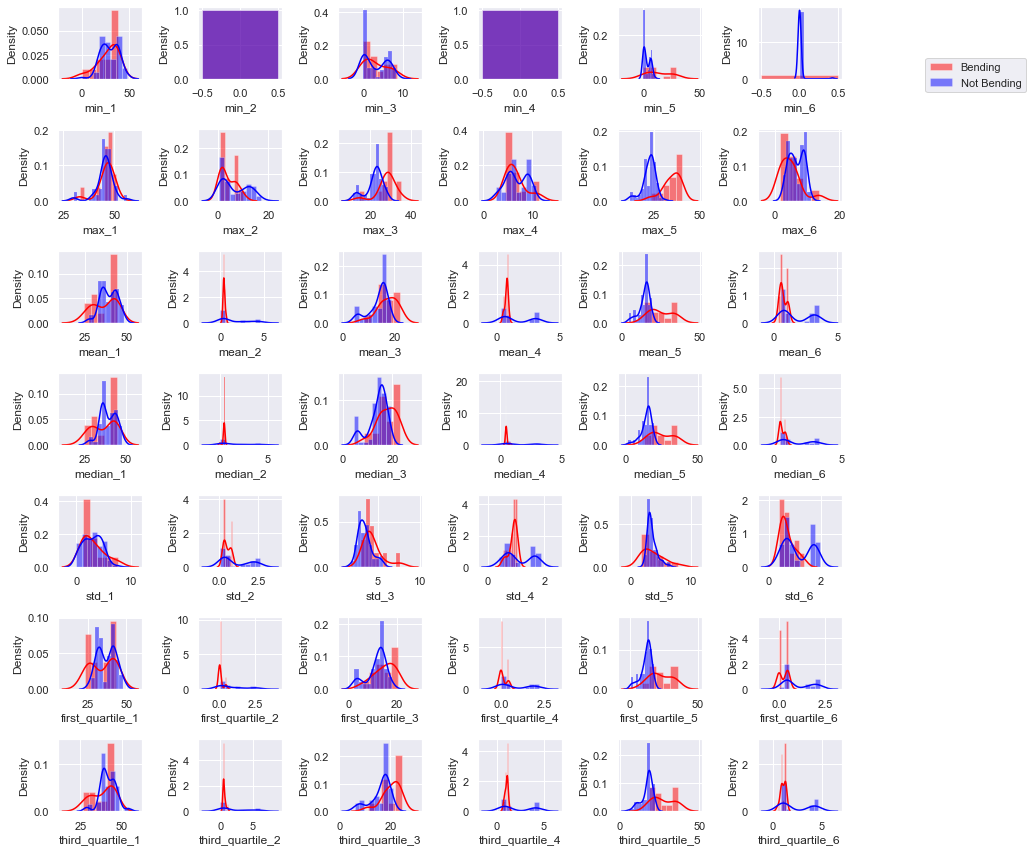

In [ ]:
features = ['min_','max_','mean_','median_','std_','first_quartile_','third_quartile_']
# https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751
# making plot for useful features as suggested on piazza
plt.figure(figsize=(12,12))
for i, ft in enumerate(features, start =1):
    for j in range(1,7):    
        plt.subplot(len(features), 6, 6*i+j-6)
        sns.histplot(bend_train.loc[bend_train['bending']== 1][ft + str(j)] ,
                     kde = True,
                     color="red",
                     stat="density",
                     edgecolor=(1, 1, 1, .4),
                     kde_kws=dict(cut=3),
                     label="Bending")
        sns.histplot(bend_train.loc[bend_train['bending']== 0][ft + str(j)], 
                     kde = True,
                     color="blue", 
                     stat="density",
                     kde_kws=dict(cut=3),
                     edgecolor=(1, 1, 1, .4),
                     label='Not Bending')
print("Different features analysis: ")
plt.tight_layout()
plt.legend(loc=(2,10))
plt.show()

I used plots to understand what features might be more useful. Not all features are equally important. Some are more significant than the others. Based on the results:
- Mean , max and third Quartile would would be useful according to me.
- Mean would give the avg val of the series, 
- max would give the peak val of the series and 
- third quartile would give the higher bound val of series.

# __Homework 4__

### __4. Binary Classification Using Logistic Regression__

#### __4(a)i. Assume that you want to use the training set to classify bending from other activities, i.e. you have a binary classification problem. Depict scatter plots of the features you specified in 1(c)iv extracted from time series 1, 2, and 6 of each instance, and use color to distinguish bending vs. other activities. (See p. 129 of the textbook)__

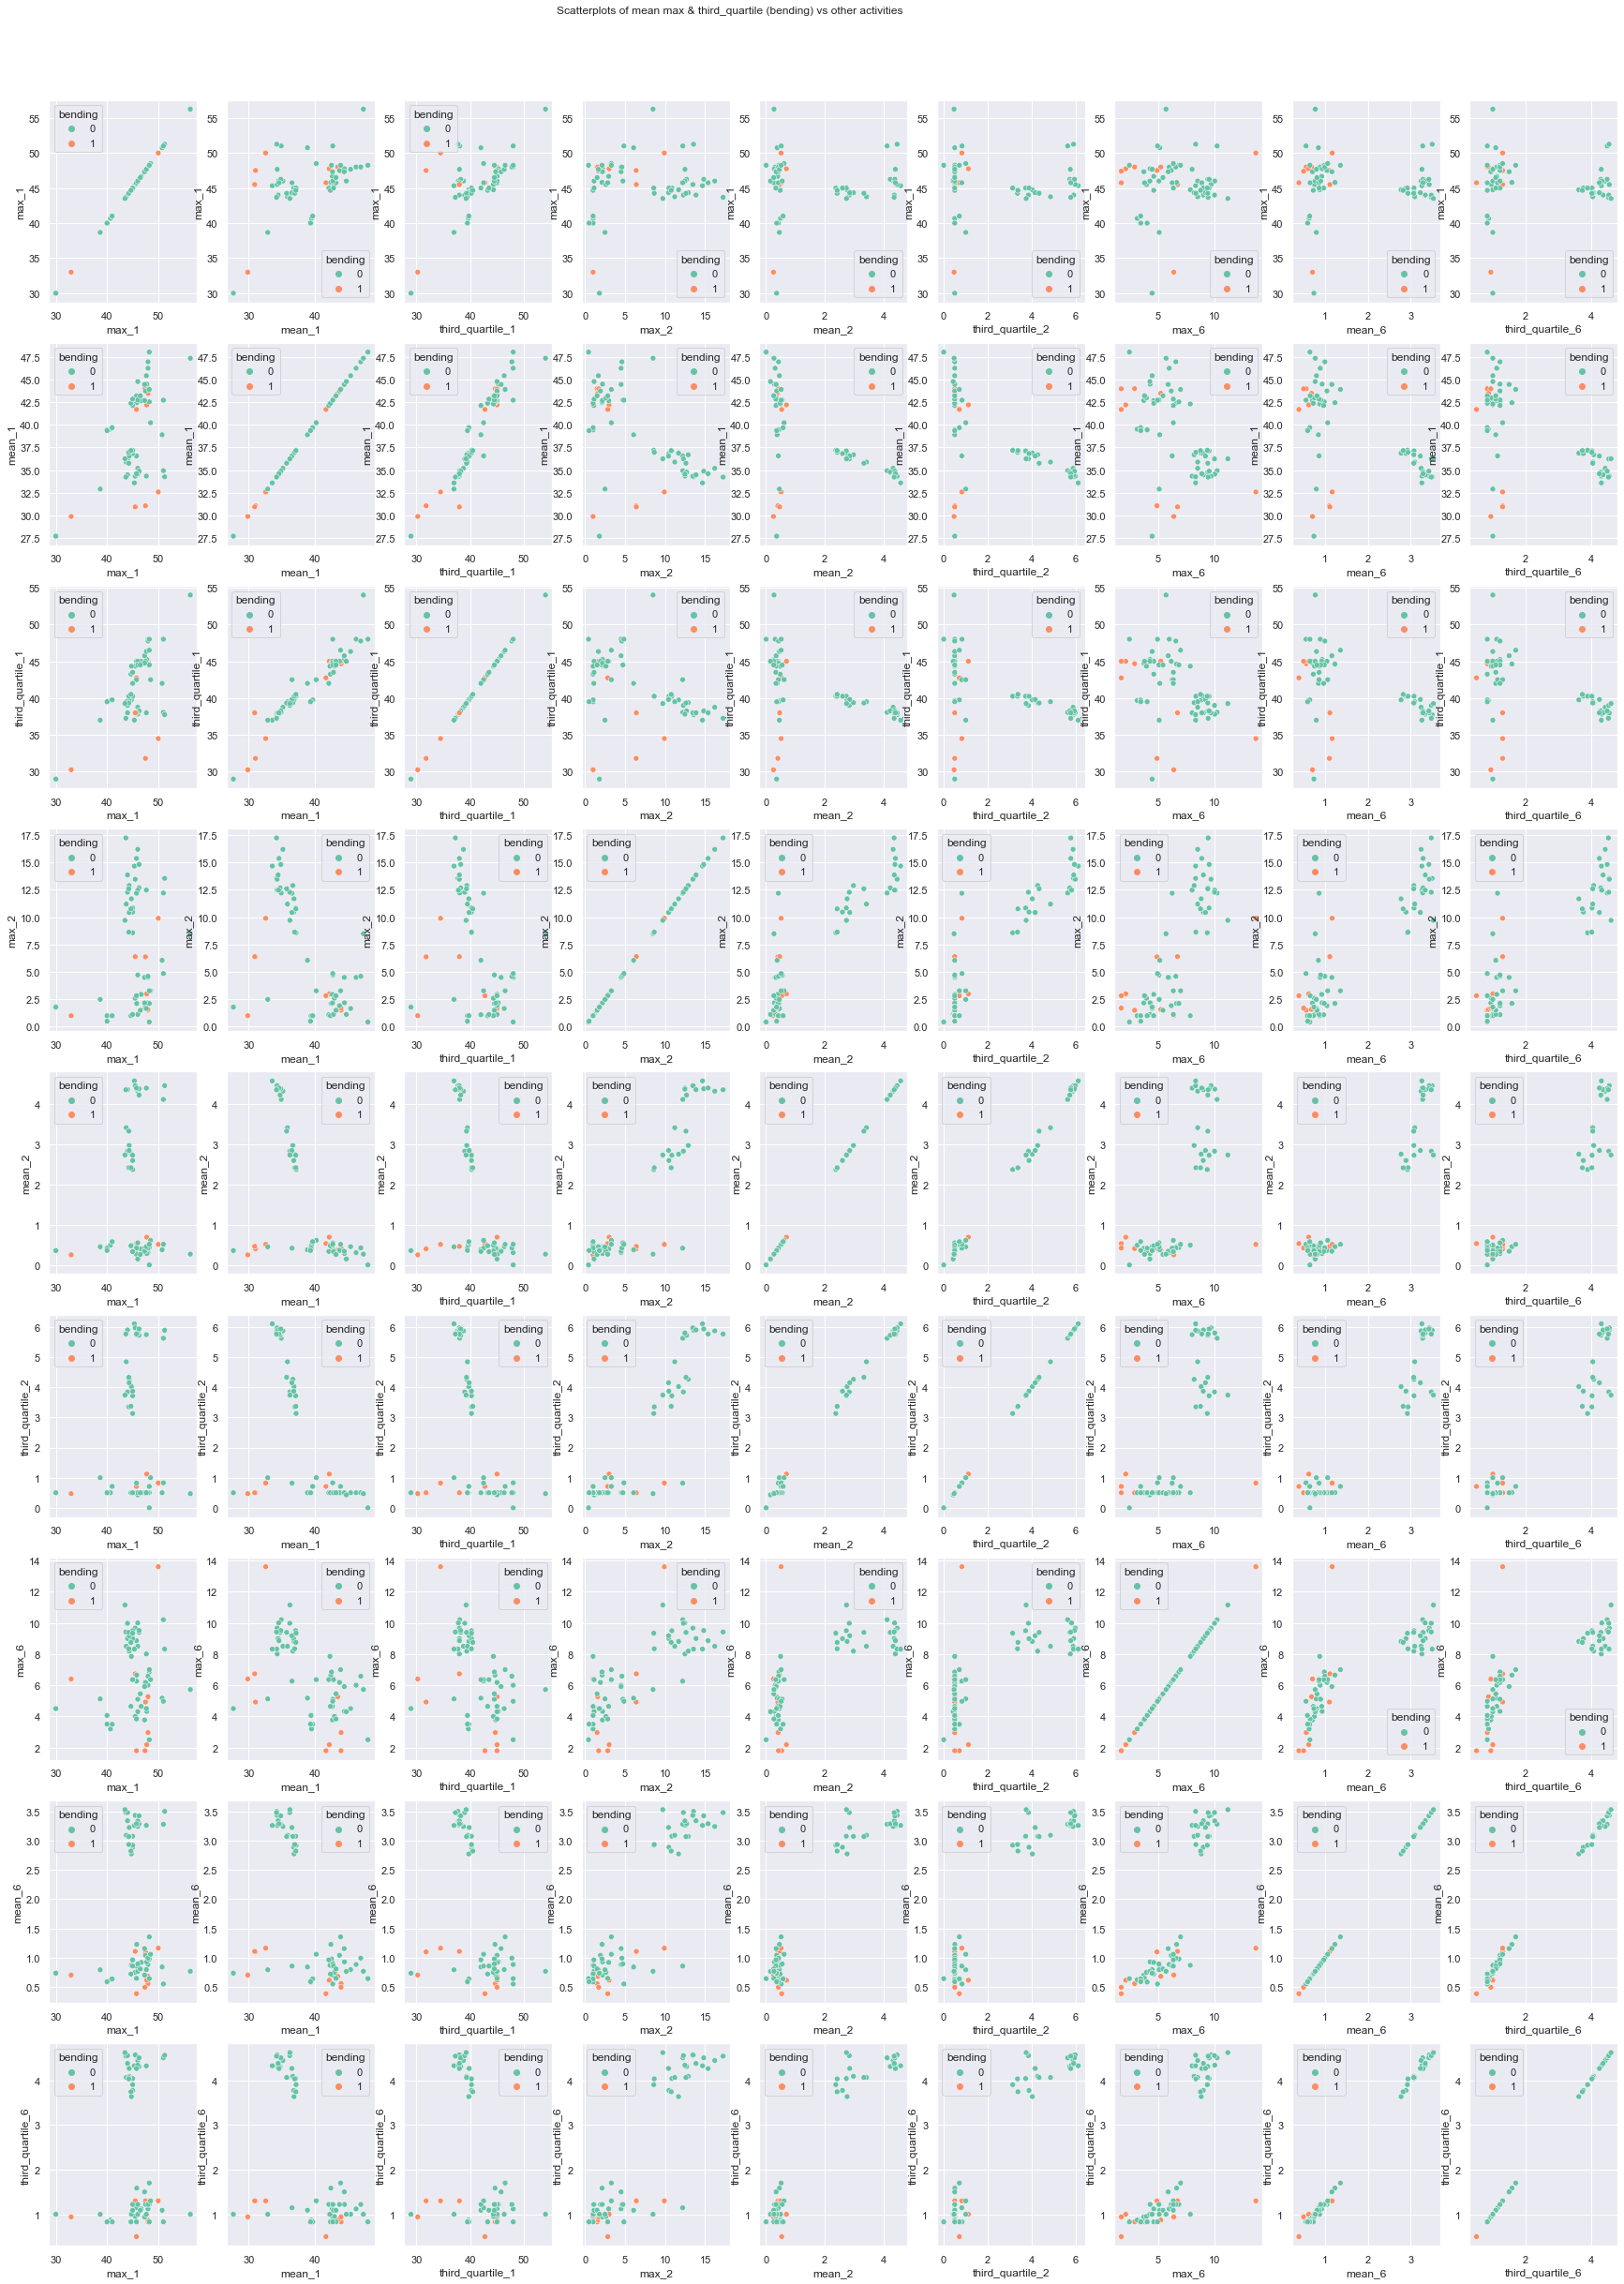

In [ ]:
# 1,26 time series of my selected features ['max_','mean_','third_quartile_']
# https://seaborn.pydata.org/generated/seaborn.scatterplot.html
series = [1,2,6]
stat = ['max_','mean_','third_quartile_'] # my selected features as mentioned on piazza
sel_features = [j+str(i) for i in series for j in stat]
bend_train = new_train_set
bend_train['bending'] = [1 if data.find('bending') != -1 else 0 
                                for data in bend_train['activity'].to_list()]
bend_train = bend_train.drop(['activity'], axis=1)

def plots(data, features, row, col, row_size, col_size):
    if features[-1] != 'bending':
        features.append('bending')
    data = data[features]
    # print(data)
    main=[]
    for i in range(0,len(data.columns)-1):
        for j in range(0,len(data.columns)-1):
            main.append([features[i], features[j]])    
    plt.close()
    fig, axs = plt.subplots(nrows= row, ncols=col, figsize=(row_size,col_size))
    k=0
    # scatterplot for given series and my selected features
    for i in range(0,col):
        for j in range(0,row):
            sns.set(font_scale=1)
            plt.subplots_adjust(top=0.92)
            scatter_plot = sns.scatterplot(data=data, x=main[k][0], y=main[k][1], hue="bending", ax=axs[j][i], palette="Set2")
            k+=1  
            plt.title("Scatterplots of mean max & third_quartile (bending) vs other activities", y=11, x = -5)
    plt.show()
plots(bend_train, sel_features, 9, 9, 30, 40)


#### __4(a)ii. Break each time series in your training set into two (approximately) equal length time series. Now instead of 6 time series for each of the training instances, you have 12 time series for each training instance. Repeat the experiment in 2(a)i, i.e depict scatter plots of the features extracted from both parts of the time series 1,2, and 6. Do you see any considerable difference in the results with those of 2(a)i?__

In [ ]:
# with activity
# reorder the columns
feature_names = ['min_','max_','mean_','median_','std_','first_quartile_','third_quartile_']
all_feat = [j+str(i) for i in range(1,13) for j in feature_names]
all_feat.append('activity')
all_feat_data = load_data(all_set, all_feat, 2)
# print(all_feat_data)

# bend train 0 or 1
stat = ['max_','mean_','third_quartile_'] # my chosen features
series2 = [1,2,3,4,11,12]
sel_features2 = [j+str(i) for i in  series2 for j in stat]
bend_train_data = all_feat_data
bend_train_data['bending'] = [1 if data.find('bending') != -1 else 0 for data in bend_train_data['activity'].to_list()]
bend_train_data = bend_train_data.drop(['activity'], axis=1)
bend_train_data

min_1  max_1     mean_1  median_1     std_1  first_quartile_1  \
0   36.67  45.00  43.486208     43.71  1.279302           42.3300   
1   39.00  48.00  44.117042     45.00  1.357000           43.5000   
2   33.75  47.75  43.278875     45.00  3.466111           42.0000   
3   33.00  45.75  41.621208     42.33  3.112140           39.6525   
4   38.00  42.33  40.946958     41.25  1.100662           40.3100   
..    ...    ...        ...       ...       ...               ...   
83  20.00  44.25  35.692167     35.50  4.633910           33.0000   
84  24.25  45.00  36.954208     36.00  3.764968           34.2500   
85  27.00  42.67  36.342750     36.75  3.640886           33.6700   
86  26.25  43.40  36.865417     36.25  3.455571           34.3100   
87  27.75  44.00  37.144583     36.67  3.796850           34.0000   

    third_quartile_1  min_2  max_2     mean_2  ...  first_quartile_11  \
0              44.50  36.25  48.00  44.452042  ...             0.0000   
1              45.00  37.00  46.50  42.792875  ...             0.4300   
2              45.25  33.00  46.00  41.080750  ...             0.0000   
3              44.25  39.25  43.67  41.734917  ...             0.0000   
4              42.00  37.25  45.00  40.302625  ...             0.0000   
..               ...    ...    ...        ...  ...                ...   
83             39.25  18.50  44.00  35.812542  ...             1.7900   
84             40.25  29.00  44.67  37.399875  ...             1.7525   
85             39.00  23.33  43.50  36.145417  ...             2.2525   
86             40.00  29.25  44.25  37.049500  ...             1.6550   
87             40.33  31.00  44.67  37.145083  ...             1.6900   

    third_quartile_11  min_12  max_12   mean_12  median_12    std_12  \
0              0.8300     0.0    2.96  0.585750       0.50  0.486900   
1              1.1200     0.0    4.06  0.543875       0.50  0.472458   
2              1.2200     0.0    2.18  0.586083       0.47  0.490847   
3              0.7100     0.0    1.50  0.347500       0.43  0.362386   
4              1.3000     0.0    1.92  0.552167       0.43  0.509430   
..                ...     ...     ...       ...        ...       ...   
83             4.3500     0.0    8.81  2.966917       2.59  1.708491   
84             3.9375     0.0    9.34  2.838083       2.45  1.886811   
85             4.7025     0.0   11.15  3.513250       3.08  1.974270   
86             4.0375     0.0    8.34  2.904458       2.57  1.606436   
87             3.9000     0.0    7.93  2.730167       2.55  1.586780   

    first_quartile_12  third_quartile_12  bending  
0              0.4225             0.8300        1  
1              0.4300             0.7100        1  
2              0.0000             0.8700        1  
3              0.0000             0.5000        1  
4              0.0000             0.9400        1  
..                ...                ...      ...  
83             1.8525             3.7400        0  
84             1.3825             3.8325        0  
85             2.1700             4.5000        0  
86             1.6900             3.7700        0  
87             1.4950             3.7050        0  

[88 rows x 85 columns]

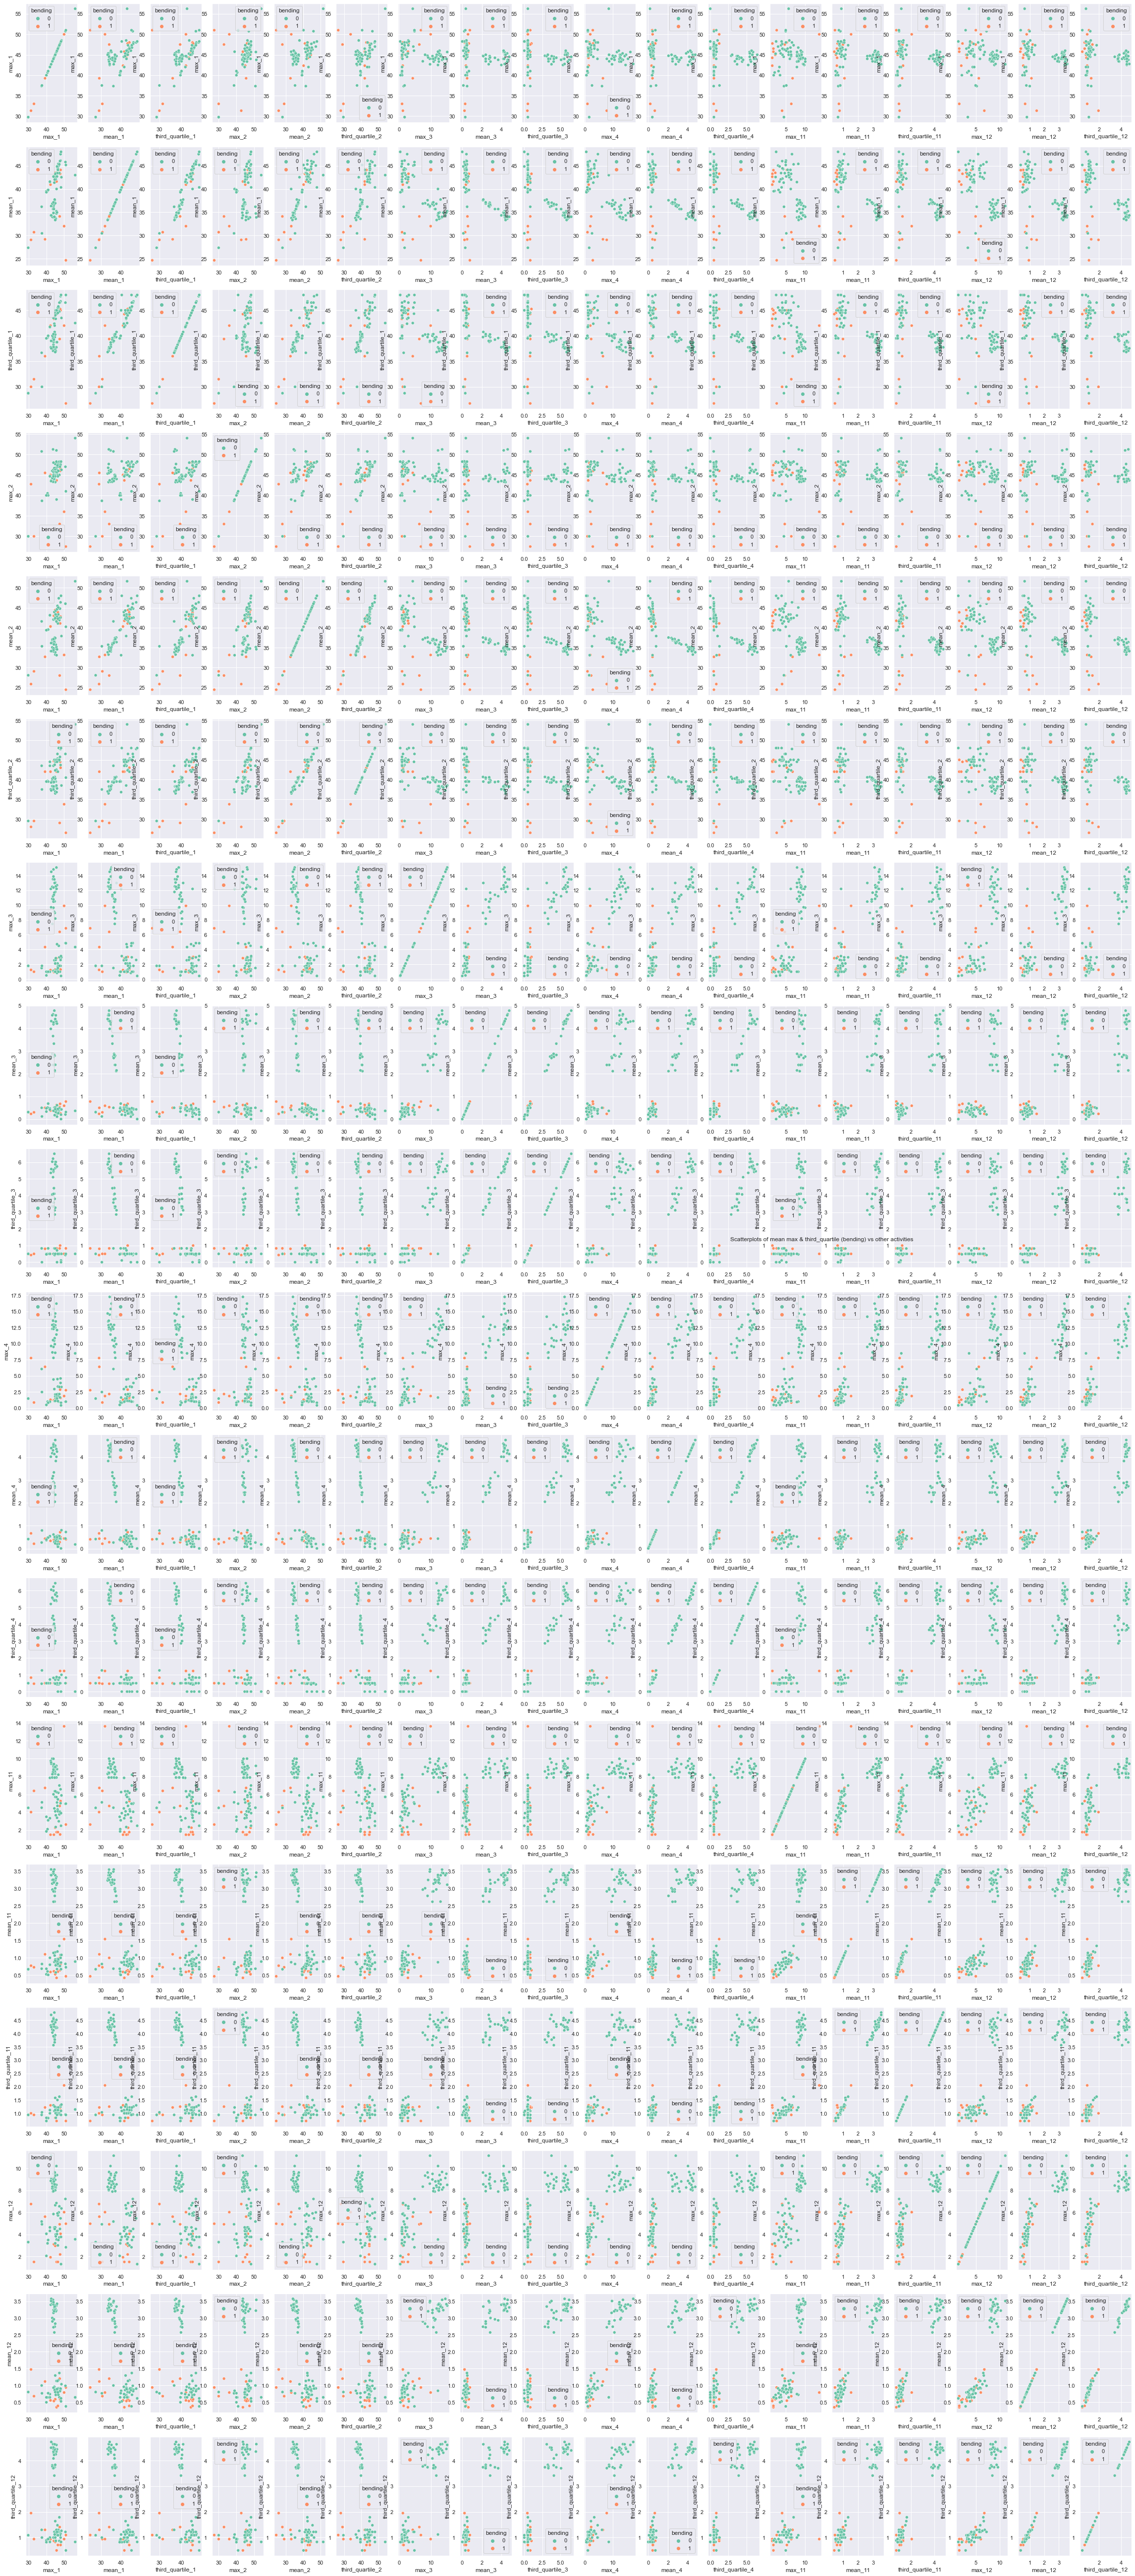

In [ ]:
plt.title("Scatterplots of mean max & third_quartile (bending) vs other activities", y=201, x = -5)
plots(bend_train_data, sel_features2, 18, 18, 40, 90)

There is not much difference between the above scatter plots and the results of those of 1 d) if we see from naked eye.The only small difference is the above graph is slightly more sparse in comparison to i d).

#### __iii. Break each time series in your training set into l ∈ {1, 2, . . . , 20} time series of approximately equal length and use logistic regression to solve the binary classification problem, using time-domain features. Remember that breaking each of the time series does not change the number of instances. It only changes the number of features for each instance. Calculate the p-values for your logistic regression parameters in each model corresponding to each value of l and refit a logistic regression model using your pruned set of features. Alternatively, you can use backward selection using sklearn.feature selection or glm in R. Use 5-fold cross-validation to determine the best value of the pair (l, p), where p is the number of features used in recursive feature elimination. Explain what the right way and the wrong way are to perform cross-validation in this problem. Obviously, use the right way! Also, you may encounter the problem of class imbalance, which may make some of your folds not having any instances of the rare class. In such a case, you can use stratified cross validation. Research what it means and use it if needed.Obviously, use the right way! Also, you may encounter the problem of class imbalance, which may make some of your folds not having any instances of the rare class. In such a case, you can use stratifiedcross validation. Research what it means and use it if needed. In the following, you can see an example of applying Python’s Recursive Feature Elimination, which is a backward selection algorithm, to logistic regression__

In [ ]:
# https://pandas.pydata.org/docs/reference/api/pandas.Series.resample.html#pandas.Series.resample
# https://stackoverflow.com/questions/69383018/best-way-to-downsample-reduce-sample-rate-non-time-series-data-in-pandas 
def downsampling(data):
    # diving dataset
    class1 = data.loc[data['bending'] == 1].shape[0]
    class0 = data.loc[data['bending'] == 0].shape[0]
    min_count = min(class1, class0)
    max_count = max(class1, class0)
    max_bending = 1 if class1 > class0 else 0
    major_sampling = data.loc[data['bending'] == max_bending]
    minor_sampling = data.loc[data['bending'] != max_bending]
    major_sampling = resample(major_sampling, n_samples = min_count * 3, replace=True, random_state=7)
    data = pd.concat([minor_sampling, major_sampling], ignore_index=True)
    return data

# https://pandas.pydata.org/docs/reference/api/pandas.Series.resample.html#pandas.Series.resample
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html
def logisticRegressionCV(train_files, k, L, downSample=False, penalty='none'):    
    columns = ['# Columns: time','avg_rss12', 'var_rss12','avg_rss13', 'var_rss13','avg_rss23', 'var_rss23']
    all_features = ['min_','max_','mean_','median_','std_','first_quartile_','third_quartile_']
    sel_lcvfeatures = [j+str(i) for i in range(1,6*L+1) for j in all_features]
    sel_lcvfeatures.append('activity')
    training_dataset = load_data(train_files, sel_lcvfeatures, L)
    training_dataset['bending'] = [1 if data.find('bending') != -1 else 0 for data in training_dataset['activity'].to_list()]
    training_dataset = training_dataset.drop(['activity'], axis=1)
    if downSample:
        training_dataset = downsampling(training_dataset)
    my_stats = ['max_','mean_','third_quartile_']
    my_features = [j+str(i) for i in range(1,6*L+1) for j in my_stats]
    my_features.append('bending')
    training_dataset = training_dataset[my_features] # splitting features and labels
    trainX = training_dataset.iloc[:,:-1]
    # print(trainX)
    trainY = training_dataset.iloc[:,-1]
    # print(trainY)
    # https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html
    stratified_cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=7)
    model = LogisticRegression(penalty=penalty, max_iter=100)
    rfecv = RFECV(estimator=model, cv=StratifiedKFold(n_splits=k, shuffle=True, random_state=7))
    rfecv.fit(trainX, trainY)
    return rfecv, model

In [ ]:
def get_features(res_df, downSample=False):
    l_pair = res_df.loc[res_df['score'] == max(res_df['score'])]
    l_val = l_pair['L'].to_list()[0] # l value
    my_lpair_features = ['max_','mean_','third_quartile_'] # taking the features that i selected 
    lcv_feat = []
    for i in range(1,6*l_val+1):
        for j in my_lpair_features:
            lcv_feat.append(j+str(i))  
    rfecv, model = logisticRegressionCV(train_set, 5, l_val, downSample=downSample)
    selected_features = [f for i, f in enumerate(lcv_feat) if rfecv.support_[i]]
    if downSample:
        feature_names = ['min_','max_','mean_','median_','std_','first_quartile_','third_quartile_']
        features_load = [j+str(i) for i in range(1,6*l_val+1) for j in feature_names]
        features_load.append('activity')
        data_lcv = load_data(train_set, features_load, l_val)
        data_lcv['bending'] = [1 if data.find('bending') != -1 else 0 for data in data_lcv['activity'].to_list()]
        data_lcv = data_lcv.drop(['activity'], axis=1)
        class1 = data_lcv.loc[data_lcv['bending'] == 1].shape[0]
        class0 = data_lcv.loc[data_lcv['bending'] == 0].shape[0]
        pi = class1 / (class1 + class0)
        pi1 = 1 / 4
        rfecv.estimator_.intercept_ += pi/(1-pi) + pi1/(1-pi1)
    return selected_features, l_val, model 

def data_splits(data, l_val, downSample=False):
    feature_names = ['min_','max_','mean_','median_','std_','first_quartile_','third_quartile_']
    features_load = [j+str(i) for i in range(1,6*l_val+1) for j in feature_names]
    features_load.append('activity')
    data_lcv = load_data(data, features_load, l_val)
    data_lcv['bending'] = [1 if data.find('bending') != -1 else 0 
                            for data in data_lcv['activity'].to_list()]
    data_lcv = data_lcv.drop(['activity'], axis=1)
    if downSample:
        data_lcv = downsampling(data_lcv)
    xdata = data_lcv.iloc[:,:-1]
    xdata = xdata[selected_features]
    ydata = data_lcv.iloc[:,-1]
    return xdata, ydata
def conf_matrix(model, xval, yval):
    model.fit(xval, yval)
    ypred = model.predict(xval)
    my_matrix = confusion_matrix(yval, ypred)
    return my_matrix
def roc_auc(xval, yval, model, dtype):
    y_pred_prob = model.predict_proba(xval)    
    fpr, tpr, thresholds = roc_curve(yval, y_pred_prob[:, 1], pos_label=1)
    roc_auc = auc(fpr, tpr)
    plt.close()
    plt.figure(figsize=(10,6))
    plt.title("ROC Curve "+ dtype +"data")
    plt.plot(fpr, tpr, 'b', label="ROC Curve : area = {}".format(roc_auc))
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    # plt.grid()
    plt.show()

In [ ]:
res_df = pd.DataFrame(columns=['L', 'p','score'])
for i in tqdm(range(1,21)):
    res_up_df=[]
    # n_split = 5
    features_selected, model = logisticRegressionCV(train_set, 5, i)
    res_up_df.extend([i, features_selected.n_features_, max(features_selected.cv_results_["mean_test_score"])])
    df_new = pd.Series(res_up_df, index = ['L', 'p', 'score'])
    res_df = res_df.append(df_new, ignore_index=True)
    res_df['L'] = res_df['L'].astype(int)
    res_df['p'] = res_df['p'].astype(int)
res_df

100%|██████████| 20/20 [02:21<00:00,  7.08s/it]


L   p     score
0    1  18  1.000000
1    2  16  0.971429
2    3   5  1.000000
3    4   6  0.985714
4    5   5  0.985714
5    6  16  0.985714
6    7   5  0.971429
7    8   9  0.985714
8    9   9  0.985714
9   10  15  0.985714
10  11  19  0.985714
11  12   8  0.985714
12  13  13  0.971429
13  14  34  0.985714
14  15  19  0.985714
15  16  37  0.985714
16  17  74  0.985714
17  18  19  0.985714
18  19  68  0.985714
19  20  29  0.985714

- For binary classification logic regression is used. RVECV is used for backward selection of feature on training data and validation is done on validation data. 

- __Cross Validation:__

   - The __right way__ is to do cross validation and find best features. Then fit the model again with selected feature and do validation.  We want to make sure that there is less variability in our feature selection process due to sample variability in our dataset. Feature selection based on logistic regression estimator is also form of training and hence requires a validation set.

   - The __wrong way__ is do feature selection with the whole training data set( Before cross validation, where we divide training data to training and validation data) and then do cross validation on our model. This is an issue because every time the dataset goes through rfe step, a different set of features may get selected and then fed into the model. Since the model will recieve different set of predictors for training, it can lead to different error and accuracy estimates which is undesirable.

The best length for logistic regression is 1 with having accuracy = 1 Thus the best pair (l,p) is (1,18)

### iv. Report the confusion matrix and show the ROC and AUC for your classifier on train data. Report the parameters of your logistic regression βi’s as well as the p-values associated with them.

l features 1 are ['max_1', 'mean_1', 'third_quartile_1', 'max_2', 'mean_2', 'third_quartile_2', 'max_3', 'mean_3', 'third_quartile_3', 'max_4', 'mean_4', 'third_quartile_4', 'max_5', 'mean_5', 'third_quartile_5', 'max_6', 'mean_6', 'third_quartile_6']
[[60  0]
 [ 0  9]]
         Current function value: 0.004585
         Iterations: 5

 Summary:
                           Logit Regression Results                           
Dep. Variable:                bending   No. Observations:                   69
Model:                          Logit   Df Residuals:                       50
Method:                           MLE   Df Model:                           18
Date:                Sun, 16 Oct 2022   Pseudo R-squ.:                  0.9882
Time:                        16:01:21   Log-Likelihood:               -0.31635
converged:                      False   LL-Null:                       -26.718
Covariance Type:            nonrobust   LLR p-value:                 2.815e-05
                     

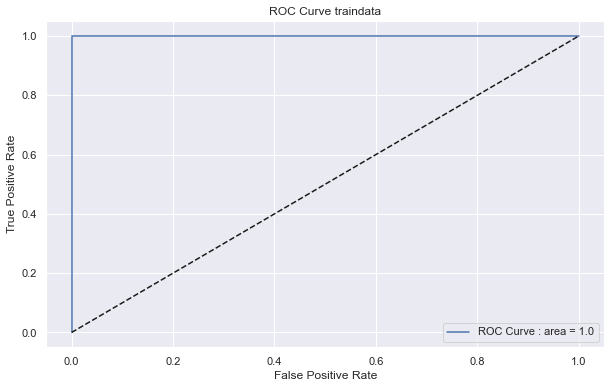

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html#sklearn.linear_mode
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html
selected_features, l_val, model = get_features(res_df)
print('l features {} are {}'.format(l_val, selected_features))
xtrain, ytrain = data_splits(train_set, l_val)
my_matrix = conf_matrix(model, xtrain, ytrain)
print(my_matrix)
train_X_add = sm.add_constant(xtrain)
#log_reg = sm.fit_regularized()
log_reg = sm.Logit(ytrain, train_X_add).fit(model='bfgs',maxiter=5)
print('')
print(" Summary:")
print(log_reg.summary())
roc_auc(xtrain, ytrain, model, 'train')



### Observations:

- Summary was unable to be generated, fitting without max iteration being provided, as there was perfect separation

### V. Test the classifier on the test set. Remember to break the time series in your test set into the same number of time series into which you broke your training set. Remember that the classifier has to be tested using the features extracted from the test set. Compare the accuracy on the test set with the cross-validation accuracy you obtained previously.

[[15  0]
 [ 0  4]]


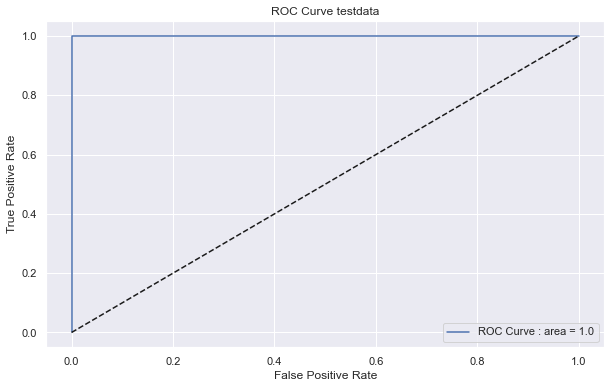

In [ ]:
selected_features, l_val, model = get_features(res_df)
xtest, ytest = data_splits(test_set, l_val)
my_matrix = conf_matrix(model, xtest, ytest)
print(my_matrix)
roc_auc(xtest, ytest, model, 'test')

#### Observation:
- AUC value as 1 for both .
- The test accuracy is as good as the cross validation accuracy. Both of the model is performing well.

### vi. Do your classes seem to be well-separated to cause instability in calculating logistic regression parameters?

__Yes,__ Classes are well separated to cause instablity. Even Logistic Regression using Statmodels suggests that there is possibly complete quasi-separation. This might indicate that there is complete quasi-separation. In this case some parameters will not be identified.

### vii. From the confusion matrices you obtained, do you see imbalanced classes? If yes, build a logistic regression model based on case-control sampling and adjust its parameters. Report the confusion matrix, ROC, and AUC of the model.

__Yes__ from the confusion matrix it is clearly evident there is imbalanced data. From training data confusion matrix we can see there is ration of bending and other activities is 60:9 , while in testing data confusion matrix ratio is 15:4
Upsampling of training data will be done to solve the problem of imbalance in the dataset


In [ ]:
res_df = pd.DataFrame(columns=['L', 'p','score'])
for i in tqdm(range(1,21)):
    res_up_df=[]
    features_selected, model = logisticRegressionCV(train_set, 5, i, downSample=True)
    res_up_df.extend([i, features_selected.n_features_, max(features_selected.cv_results_["mean_test_score"])])
    df_new = pd.Series(res_up_df, index = ['L', 'p', 'score'])
    res_df = res_df.append(df_new, ignore_index=True)
    res_df['L'] = res_df['L'].astype(int)
    res_df['p'] = res_df['p'].astype(int)
res_df

100%|██████████| 20/20 [02:07<00:00,  6.37s/it]


L   p     score
0    1   6  1.000000
1    2  14  0.975000
2    3   5  0.975000
3    4  10  1.000000
4    5   8  0.975000
5    6   8  1.000000
6    7  11  0.975000
7    8  25  0.975000
8    9  41  0.975000
9   10  39  0.971429
10  11  91  1.000000
11  12   7  0.975000
12  13  50  1.000000
13  14  36  0.971429
14  15  40  1.000000
15  16   2  1.000000
16  17  55  0.971429
17  18   8  0.975000
18  19  51  0.971429
19  20   2  0.971429

the best features are : 1 are ['third_quartile_1', 'max_2', 'max_5', 'mean_5', 'third_quartile_5', 'max_6']
[[27  0]
 [ 0  9]]


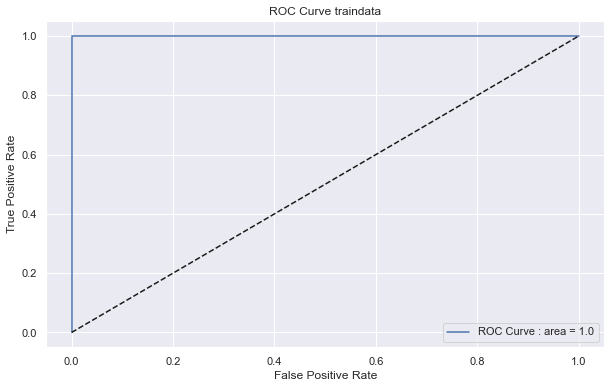

In [ ]:
selected_features, l_val, model = get_features(res_df, downSample=True)
print('the best features are : {} are {}'.format(l_val, selected_features))
xtrain, ytrain = data_splits(train_set, l_val, downSample=True)
my_matrix = conf_matrix(model, xtrain, ytrain)
print(my_matrix)
roc_auc(xtrain, ytrain, model, 'train')

[[15  0]
 [ 0  4]]


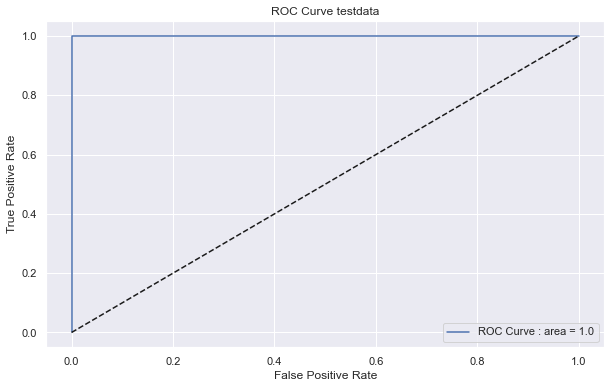

In [ ]:
xtest, ytest = data_splits(test_set, l_val)
my_matrix = conf_matrix(model, xtest, ytest)
print(my_matrix)
roc_auc(xtest, ytest, model, 'test')

Accuracy and F1 score of Upscaled model is 1. Both the model performance is same



## (b) Binary Classification Using L1-penalized logistic regression

### i. Repeat 2(a)iii using L1-penalized logistic regression, i.e. instead of using p-values for variable selection, use L1 regularization. Note that in this problem, you have to cross-validate for both l, the number of time series into which you break each of your instances, and λ, the weight of L1 penalty in your logistic regression objective function (or C, the budget). Packages usually perform cross-validation for λ automatically.

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

def log_dataset(train_set, test_set, L, class_type, binary_class=True, multi_class='auto'):    
    orig_columns = ['# Columns: time','avg_rss12', 'var_rss12','avg_rss13', 'var_rss13','avg_rss23', 'var_rss23']
    features = ['min_','max_','mean_','median_','std','first_quartile_','third_quartile_']
    sel_lcvfeatures = [name+str(i) for i in range(1,6*L+1) for name in features]
    sel_lcvfeatures.append('activity')
    training_dataset = load_data(train_set, sel_lcvfeatures, L) # loading data with givern l
    testing_dataset = load_data(test_set, sel_lcvfeatures, L) 
    if binary_class:
        training_dataset['bending'] = [1 if data.find('bending') != -1 else 0 for data in training_dataset['activity'].to_list()]
        training_dataset = training_dataset.drop(['activity'], axis=1)
        training_dataset.rename(columns={'bending':'activity'}, inplace=True)
        testing_dataset['bending'] = [1 if data.find('bending') != -1 else 0 for data in testing_dataset['activity'].to_list()]
        testing_dataset = testing_dataset.drop(['activity'], axis=1)
        testing_dataset.rename(columns={'bending':'activity'}, inplace=True)
    my_features = ['max_','mean_','third_quartile_']
    my_new_features = [name+str(i) for i in range(1,6*L+1) for name in my_features]
    my_new_features.append('activity')
    training_dataset = training_dataset[my_new_features]
    testing_dataset = testing_dataset[my_new_features]
    trainX, trainY = training_dataset.iloc[:, :-1], training_dataset.iloc[:, -1] # splitting datat and label
    testX, testY = testing_dataset.iloc[:, :-1], testing_dataset.iloc[:, -1]
    if multi_class == 'multinomial':
        solver = 'saga'
    else:
        solver = 'liblinear'
    if class_type == 'LogisticRegressionCV':    
        model = LogisticRegressionCV(penalty='l1', solver=solver, multi_class=multi_class, cv=5, random_state=7)
    elif class_type == 'LogisticRegression':
        model = LogisticRegression(penalty='l1', solver=solver, multi_class=multi_class)
    elif class_type == 'GaussianNB':
        model = GaussianNB()
    elif class_type == 'MultinomialNB':
        model = MultinomialNB()
    model.fit(trainX, trainY)
    trscore = model.score(trainX, trainY)
    ts_score = model.score(testX, testY)
    return model, 1 - trscore, 1 - ts_score

In [ ]:
def log_cv_split(l_val, class_type, binary_class=True):
    feature_names = ['min_','max_','mean_','median_','std','first_quartile_','third_quartile_']
    features_load = [name+str(i) for i in range(1,6*l_val+1) for name in feature_names]
    features_load.append('activity')
    
    training_dataset = load_data(train_set, features_load, l_val)
    testing_dataset = load_data(test_set, features_load, l_val)
    if binary_class:
        training_dataset['bending'] = [1 if data.find('bending') != -1 else 0 
                                for data in training_dataset['activity'].to_list()]
        training_dataset = training_dataset.drop(['activity'], axis=1)
        training_dataset.rename(columns={'bending':'activity'}, inplace=True)
        testing_dataset['bending'] = [1 if data.find('bending') != -1 else 0 
                                for data in testing_dataset['activity'].to_list()]
        testing_dataset = testing_dataset.drop(['activity'], axis=1)
        testing_dataset.rename(columns={'bending':'activity'}, inplace=True)
    my_features = ['max_','mean_','third_quartile_']
    my_new_features = [name+str(i) for i in range(1,6*l_val+1) for name in my_features]
    my_new_features.append('activity')
    training_dataset = training_dataset[my_new_features]
    testing_dataset = testing_dataset[my_new_features]
    xtrain = training_dataset.iloc[:,:-1]
    ytrain = training_dataset.iloc[:,-1]
    xtest = testing_dataset.iloc[:,:-1]
    ytest = testing_dataset.iloc[:,-1]
    if binary_class and class_type == 'LogisticRegression':
        model, training_err, testing_err = log_dataset(train_set, test_set, l_val, 'LogisticRegression')
    elif binary_class == False and class_type == 'LogisticRegression':
        model, training_err, testing_err = log_dataset(train_set, test_set, l_val, 'LogisticRegression', binary_class=False, multi_class='multinomial')
    elif binary_class == False and class_type == 'GaussianNB':
        model, training_err, testing_err = log_dataset(train_set, test_set, l_val, 'GaussianNB', binary_class=False)
    elif binary_class == False and class_type == 'MultinomialNB':
        model, training_err, testing_err = log_dataset(train_set, test_set, l_val, 'MultinomialNB', binary_class=False)    
    return xtrain, ytrain, xtest, ytest, model

In [ ]:
res_df = pd.DataFrame(columns=['L', 'training_err','testing_err'])
for i in tqdm(range(1,21)):
    res_up_df=[]
    model, training_err, testing_err = log_dataset(train_set, test_set, i, 'LogisticRegressionCV')
    res_up_df.extend([i, training_err, testing_err])
    df_new = pd.Series(res_up_df, index = ['L', 'training_err', 'testing_err'])
    res_df = res_df.append(df_new, ignore_index=True)
    res_df['L'] = res_df['L'].astype(int)
res_df

100%|██████████| 20/20 [01:16<00:00,  3.85s/it]


L  training_err  testing_err
0    1      0.000000     0.000000
1    2      0.043478     0.052632
2    3      0.000000     0.000000
3    4      0.000000     0.052632
4    5      0.000000     0.052632
5    6      0.000000     0.000000
6    7      0.000000     0.052632
7    8      0.000000     0.052632
8    9      0.000000     0.000000
9   10      0.000000     0.052632
10  11      0.000000     0.052632
11  12      0.028986     0.052632
12  13      0.028986     0.052632
13  14      0.028986     0.052632
14  15      0.000000     0.052632
15  16      0.028986     0.052632
16  17      0.014493     0.052632
17  18      0.014493     0.052632
18  19      0.014493     0.052632
19  20      0.000000     0.052632

[[60  0]
 [ 0  9]]


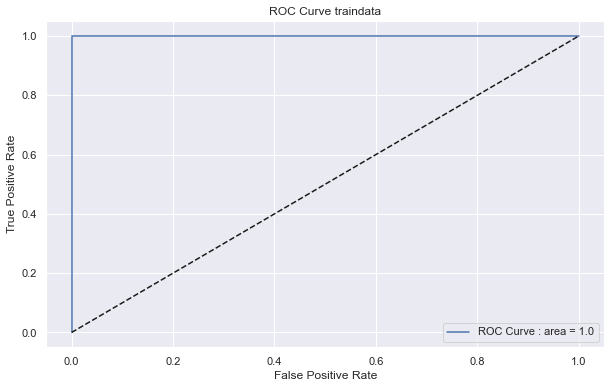

In [ ]:
lp_score = res_df.loc[res_df['testing_err'] == min(res_df['testing_err'])]
l_val = lp_score['L'].to_list()[0]
xtrain, ytrain, xtest, ytest, model = log_cv_split(l_val, 'LogisticRegression')
my_matrix = conf_matrix(model, xtrain, ytrain)
print(my_matrix)
roc_auc(xtrain, ytrain, model, 'train')


[[15  0]
 [ 0  4]]


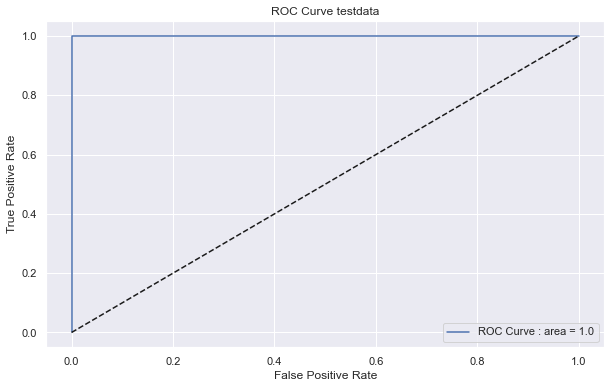

In [ ]:
my_matrix = conf_matrix(model, xtest, ytest)
print(my_matrix)
roc_auc(xtest, ytest, model, 'test')

### ii. Compare the L1-penalized with variable selection using p-values. Which one performs better? Which one is easier to implement?

#### Performance
- Based on the logged cross validation score during model iterations, we can see that the L1-penalized model has a better performance on cross validation and a pretty good score (1.0 accuracy) for test set as well. 
- To justify this, we can also see the time taken for iterations. From results, logged model takes 6.61sec/iteration and L1-penalized model takes only 3.88sec/iteration. Almost there is 40% decrease in time for L1-penalized model.

#### Implementation 
- TThe L1 penalized is easier to implement as compare to Variable selection with RFECV. Because, In feature selection using p-values, we need to manually select features and remove insignificant ones to form best fit model. But in L1-penalized model, it is automated. Also computation is faster for L1 penalized as compare to Variable selection with RFECV. Backward selection with lot of features takes more time to give result. Also with backward selection we had to use max iteration which was not necessary for L1 penalized model.

## (c) Multi-class Classification (The Realistic Case)

### i. Find the best l in the same way as you found it in 2(b)i to build an L1- penalized multinomial regression model to classify all activities in your training set. Report your test error. Research how confusion matrices and ROC curves are defined for multiclass classification and show them for this problem if possible.

L 1 - penalized multinomial regression


In [ ]:
def roc_auc_updated(data_X, data_Y, model, data_type):
    predict_Y_prob_estimates = model.predict_proba(data_X)
    plt.close()
    plt.figure(figsize=(10,6))
    for idx, activity in enumerate(model.classes_):
        fpr, tpr, thresholds = roc_curve(data_Y, predict_Y_prob_estimates[:, idx], pos_label=activity)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label="AUC {} : {}".format(activity, roc_auc))
    plt.plot([0,1], [0,1], 'k--')
    plt.title('ROC Curve {} data'.format(data_type))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
res_df = pd.DataFrame(columns=['L', 'training_err','testing_err'])
for i in tqdm(range(1, 21)):
    res_up_df=[]
    model, training_err, testing_err = log_dataset(train_set, test_set, i, 'LogisticRegressionCV', binary_class=False, multi_class='multinomial')
    res_up_df.extend([i, training_err, testing_err])
    df_new = pd.Series(res_up_df, index = ['L', 'training_err', 'testing_err'])
    res_df = res_df.append(df_new, ignore_index=True)
    res_df['L'] = res_df['L'].astype(int)
res_df

100%|██████████| 20/20 [01:42<00:00,  5.11s/it]


L  training_err  testing_err
0    1      0.028986     0.052632
1    2      0.000000     0.105263
2    3      0.000000     0.157895
3    4      0.028986     0.105263
4    5      0.000000     0.105263
5    6      0.000000     0.210526
6    7      0.000000     0.157895
7    8      0.000000     0.210526
8    9      0.000000     0.157895
9   10      0.000000     0.157895
10  11      0.000000     0.210526
11  12      0.000000     0.210526
12  13      0.000000     0.210526
13  14      0.000000     0.210526
14  15      0.000000     0.210526
15  16      0.000000     0.210526
16  17      0.000000     0.210526
17  18      0.000000     0.263158
18  19      0.014493     0.157895
19  20      0.014493     0.210526

Confusion matrix of training data for L1- penalized multinomial regression model is:

[[ 4  0  0  0  1  0  0]
 [ 1  3  0  0  0  0  0]
 [ 0  0 12  0  0  0  0]
 [ 0  0  0 12  0  0  0]
 [ 0  0  0  0 11  1  0]
 [ 0  0  0  0  1 11  0]
 [ 0  0  0  0  0  0 12]]


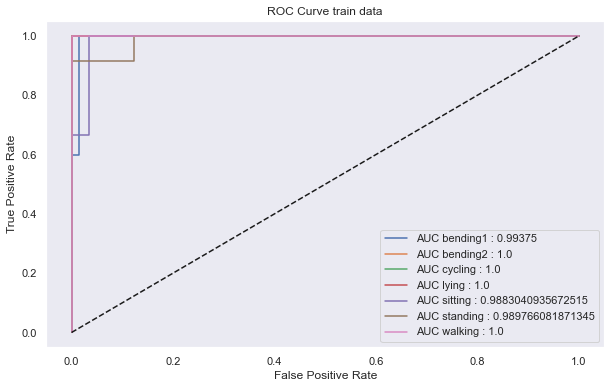

In [ ]:
lp_score = res_df.loc[res_df['testing_err'] == min(res_df['testing_err'])]
l_val = lp_score['L'].to_list()[0]
xtrain, ytrain, xtest, ytest, model = log_cv_split(l_val, 'LogisticRegression', binary_class=False)
print("Confusion matrix of training data for L1- penalized multinomial regression model is:\n")
my_matrix = conf_matrix(model, xtrain, ytrain)
print(my_matrix)
roc_auc_updated(xtrain, ytrain, model, 'train')

[[2 0 0 0 0 0 0]
 [0 2 0 0 0 0 0]
 [0 0 3 0 0 0 0]
 [0 0 0 3 0 0 0]
 [0 0 0 0 3 0 0]
 [0 0 0 0 0 3 0]
 [0 0 0 0 0 0 3]]


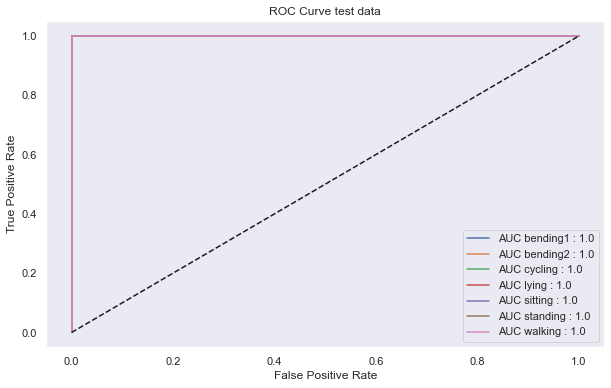

In [ ]:
my_matrix = conf_matrix(model, xtest, ytest)
print("Confusion matrix of testing datafor L1- penalized multinomial regression is:\n")
print(my_matrix)
roc_auc_updated(xtest, ytest, model, 'test')

- From the above confusion matrix, it can be observed that all classes (the one in diagonal ) are classified correctly

### ii. Repeat 2(c)i using a Naive Bayes’ classifier. Use both Gaussian and Multinomial priors and compare the results.

### Gaussian Naive Bayes

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html 
nb_result = pd.DataFrame(columns=['L', 'training_err','testing_err'])
for i in tqdm(range(1, 21)):
    res_up_df=[]
    nb_model, training_err, testing_err = log_dataset(train_set, test_set, i, 'GaussianNB', binary_class=False)
    res_up_df.extend([i, training_err, testing_err])
    df_new = pd.Series(res_up_df, index = ['L', 'training_err', 'testing_err'])
    nb_result = nb_result.append(df_new, ignore_index=True)
    nb_result['L'] = nb_result['L'].astype(int)
nb_result

100%|██████████| 20/20 [01:16<00:00,  3.80s/it]


L  training_err  testing_err
0    1      0.057971     0.000000
1    2      0.014493     0.052632
2    3      0.014493     0.105263
3    4      0.014493     0.105263
4    5      0.014493     0.105263
5    6      0.014493     0.157895
6    7      0.000000     0.157895
7    8      0.014493     0.105263
8    9      0.000000     0.157895
9   10      0.000000     0.157895
10  11      0.000000     0.157895
11  12      0.000000     0.157895
12  13      0.014493     0.157895
13  14      0.000000     0.157895
14  15      0.000000     0.210526
15  16      0.000000     0.157895
16  17      0.000000     0.157895
17  18      0.000000     0.157895
18  19      0.000000     0.157895
19  20      0.000000     0.157895

[[ 5  0  0  0  0  0  0]
 [ 0  3  0  1  0  0  0]
 [ 0  0 12  0  0  0  0]
 [ 0  0  0 12  0  0  0]
 [ 1  0  0  0  9  2  0]
 [ 0  0  0  0  0 12  0]
 [ 0  0  0  0  0  0 12]]


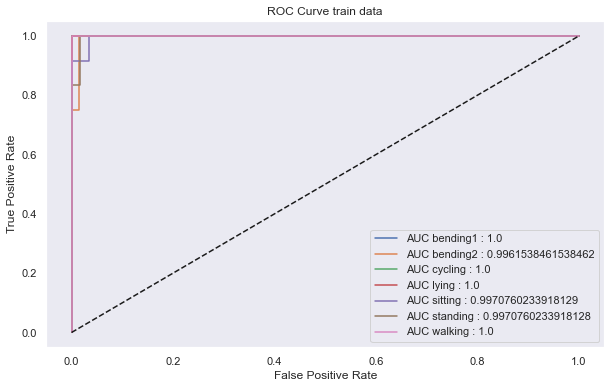

In [ ]:
lp_score = nb_result.loc[nb_result['testing_err'] == min(nb_result['testing_err'])]
l_val = lp_score['L'].to_list()[0]
xtrain, ytrain, xtest, ytest, model = log_cv_split(l_val, 'GaussianNB', binary_class=False)
my_matrix = conf_matrix(model, xtrain, ytrain)
print("Confusion matrix for training data with Gaus Naive Bayes  is:\n")
print(my_matrix)
roc_auc_updated(xtrain, ytrain, model, 'train')

[[2 0 0 0 0 0 0]
 [0 2 0 0 0 0 0]
 [0 0 3 0 0 0 0]
 [0 0 0 3 0 0 0]
 [0 0 0 0 3 0 0]
 [0 0 0 0 0 3 0]
 [0 0 0 0 0 0 3]]


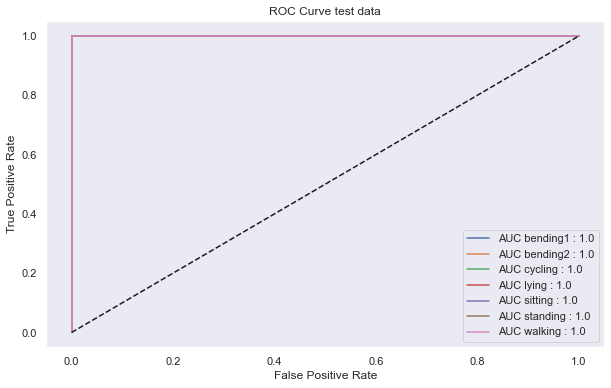

In [ ]:
my_matrix = conf_matrix(model, xtest, ytest)
print("Confusion matrix for testing data with Gaus Naive Bayer's is:\n")
print(my_matrix)
roc_auc_updated(xtest, ytest, model, 'test')

### Multinomial Naive Bayes

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html
nb_result = pd.DataFrame(columns=['L', 'training_err','testing_err'])
for i in tqdm(range(1, 21)):
    res_up_df=[]
    nb_model, training_err, testing_err = log_dataset(train_set, test_set, i, 'MultinomialNB', binary_class=False)
    res_up_df.extend([i, training_err, testing_err])
    df_new = pd.Series(res_up_df, index = ['L', 'training_err', 'testing_err'])
    nb_result = nb_result.append(df_new, ignore_index=True)
    nb_result['L'] = nb_result['L'].astype(int)
nb_result

100%|██████████| 20/20 [01:15<00:00,  3.77s/it]


L  training_err  testing_err
0    1      0.101449     0.052632
1    2      0.086957     0.105263
2    3      0.057971     0.105263
3    4      0.028986     0.052632
4    5      0.043478     0.052632
5    6      0.028986     0.052632
6    7      0.028986     0.052632
7    8      0.043478     0.105263
8    9      0.043478     0.105263
9   10      0.043478     0.105263
10  11      0.057971     0.105263
11  12      0.043478     0.105263
12  13      0.057971     0.105263
13  14      0.043478     0.105263
14  15      0.057971     0.105263
15  16      0.057971     0.105263
16  17      0.057971     0.105263
17  18      0.057971     0.157895
18  19      0.057971     0.105263
19  20      0.057971     0.105263

[[ 4  0  0  0  1  0  0]
 [ 0  3  0  0  1  0  0]
 [ 0  0 12  0  0  0  0]
 [ 0  0  0 10  2  0  0]
 [ 0  1  0  0 10  1  0]
 [ 0  0  0  0  1 11  0]
 [ 0  0  0  0  0  0 12]]


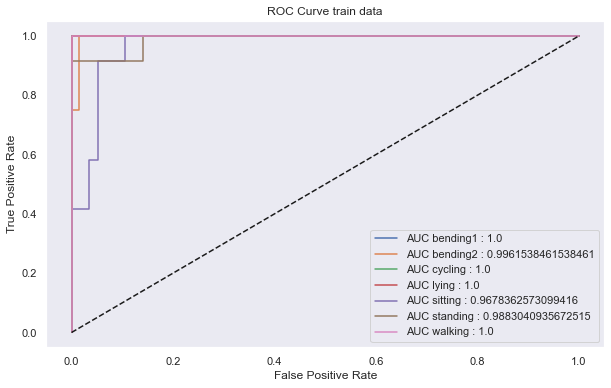

In [ ]:
lp_score = nb_result.loc[nb_result['testing_err'] == min(nb_result['testing_err'])]
l_val = lp_score['L'].to_list()[0]
xtrain, ytrain, xtest, ytest, model = log_cv_split(l_val, 'MultinomialNB', binary_class=False)
my_matrix = conf_matrix(model, xtrain, ytrain)
print("Confusion matrix on train set:\n {}".format(my_matrix))
roc_auc_updated(xtrain, ytrain, model, 'train')

[[2 0 0 0 0 0 0]
 [0 2 0 0 0 0 0]
 [0 0 3 0 0 0 0]
 [0 0 0 2 0 1 0]
 [0 0 0 0 3 0 0]
 [0 0 0 0 0 3 0]
 [0 0 0 0 0 0 3]]


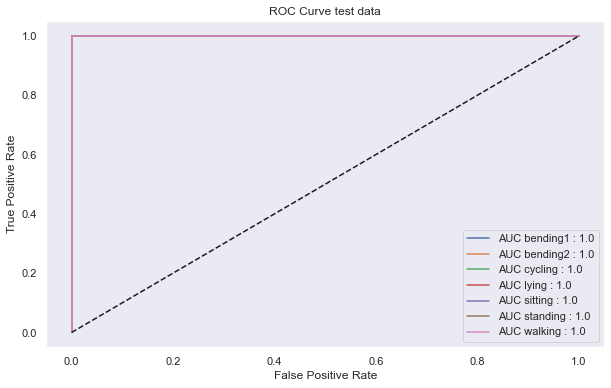

In [ ]:
my_matrix = conf_matrix(model, xtest, ytest)
print("Confusion matrix on test set:\n {}".format(my_matrix))
roc_auc_updated(xtest, ytest, model, 'test')

### iii. Which method is better for multi-class classification in this problem?

**Logistic Multinomial Vs Gaussian Naive Bayes Vs Multinomial Naive Bayes**
- ROC-AUC curves are similar for all three classifiers
- Test error is minimum for Gaussian Naive Bayes
- Out of all Train ROC-AUC curves, Gaussian Naive Bayes gives best ROC with AUC for all activities near to 1

From the above data it is clearly evident Gaussian Naive Baye's model performed better compare to Mutinomial Naive Bayes and L1 Multionmial Bayes's model. Thus for this given dataset for multi class classification problem, Gaussian Naive Baye's model is the best among above all given model.

# 3. ISLR 4.8.3


This problem relates to the QDA model, in which the observations within each class are drawn from a normal distribution with a class specific mean vector and a class specific covariance matrix. We consider the simple case where p = 1; i.e. there is only one feature.

Suppose that we have K classes, and that if an observation belongs to the kth class then X comes from a one dimensional normal distribution, X ∼ N($μ_k,{σ_k}^2$). Recall that the density function for the one dimensional normal distribution is given in (4.16). Prove that in this case, the Bayes classifier is not linear. Argue that it is in fact quadratic.

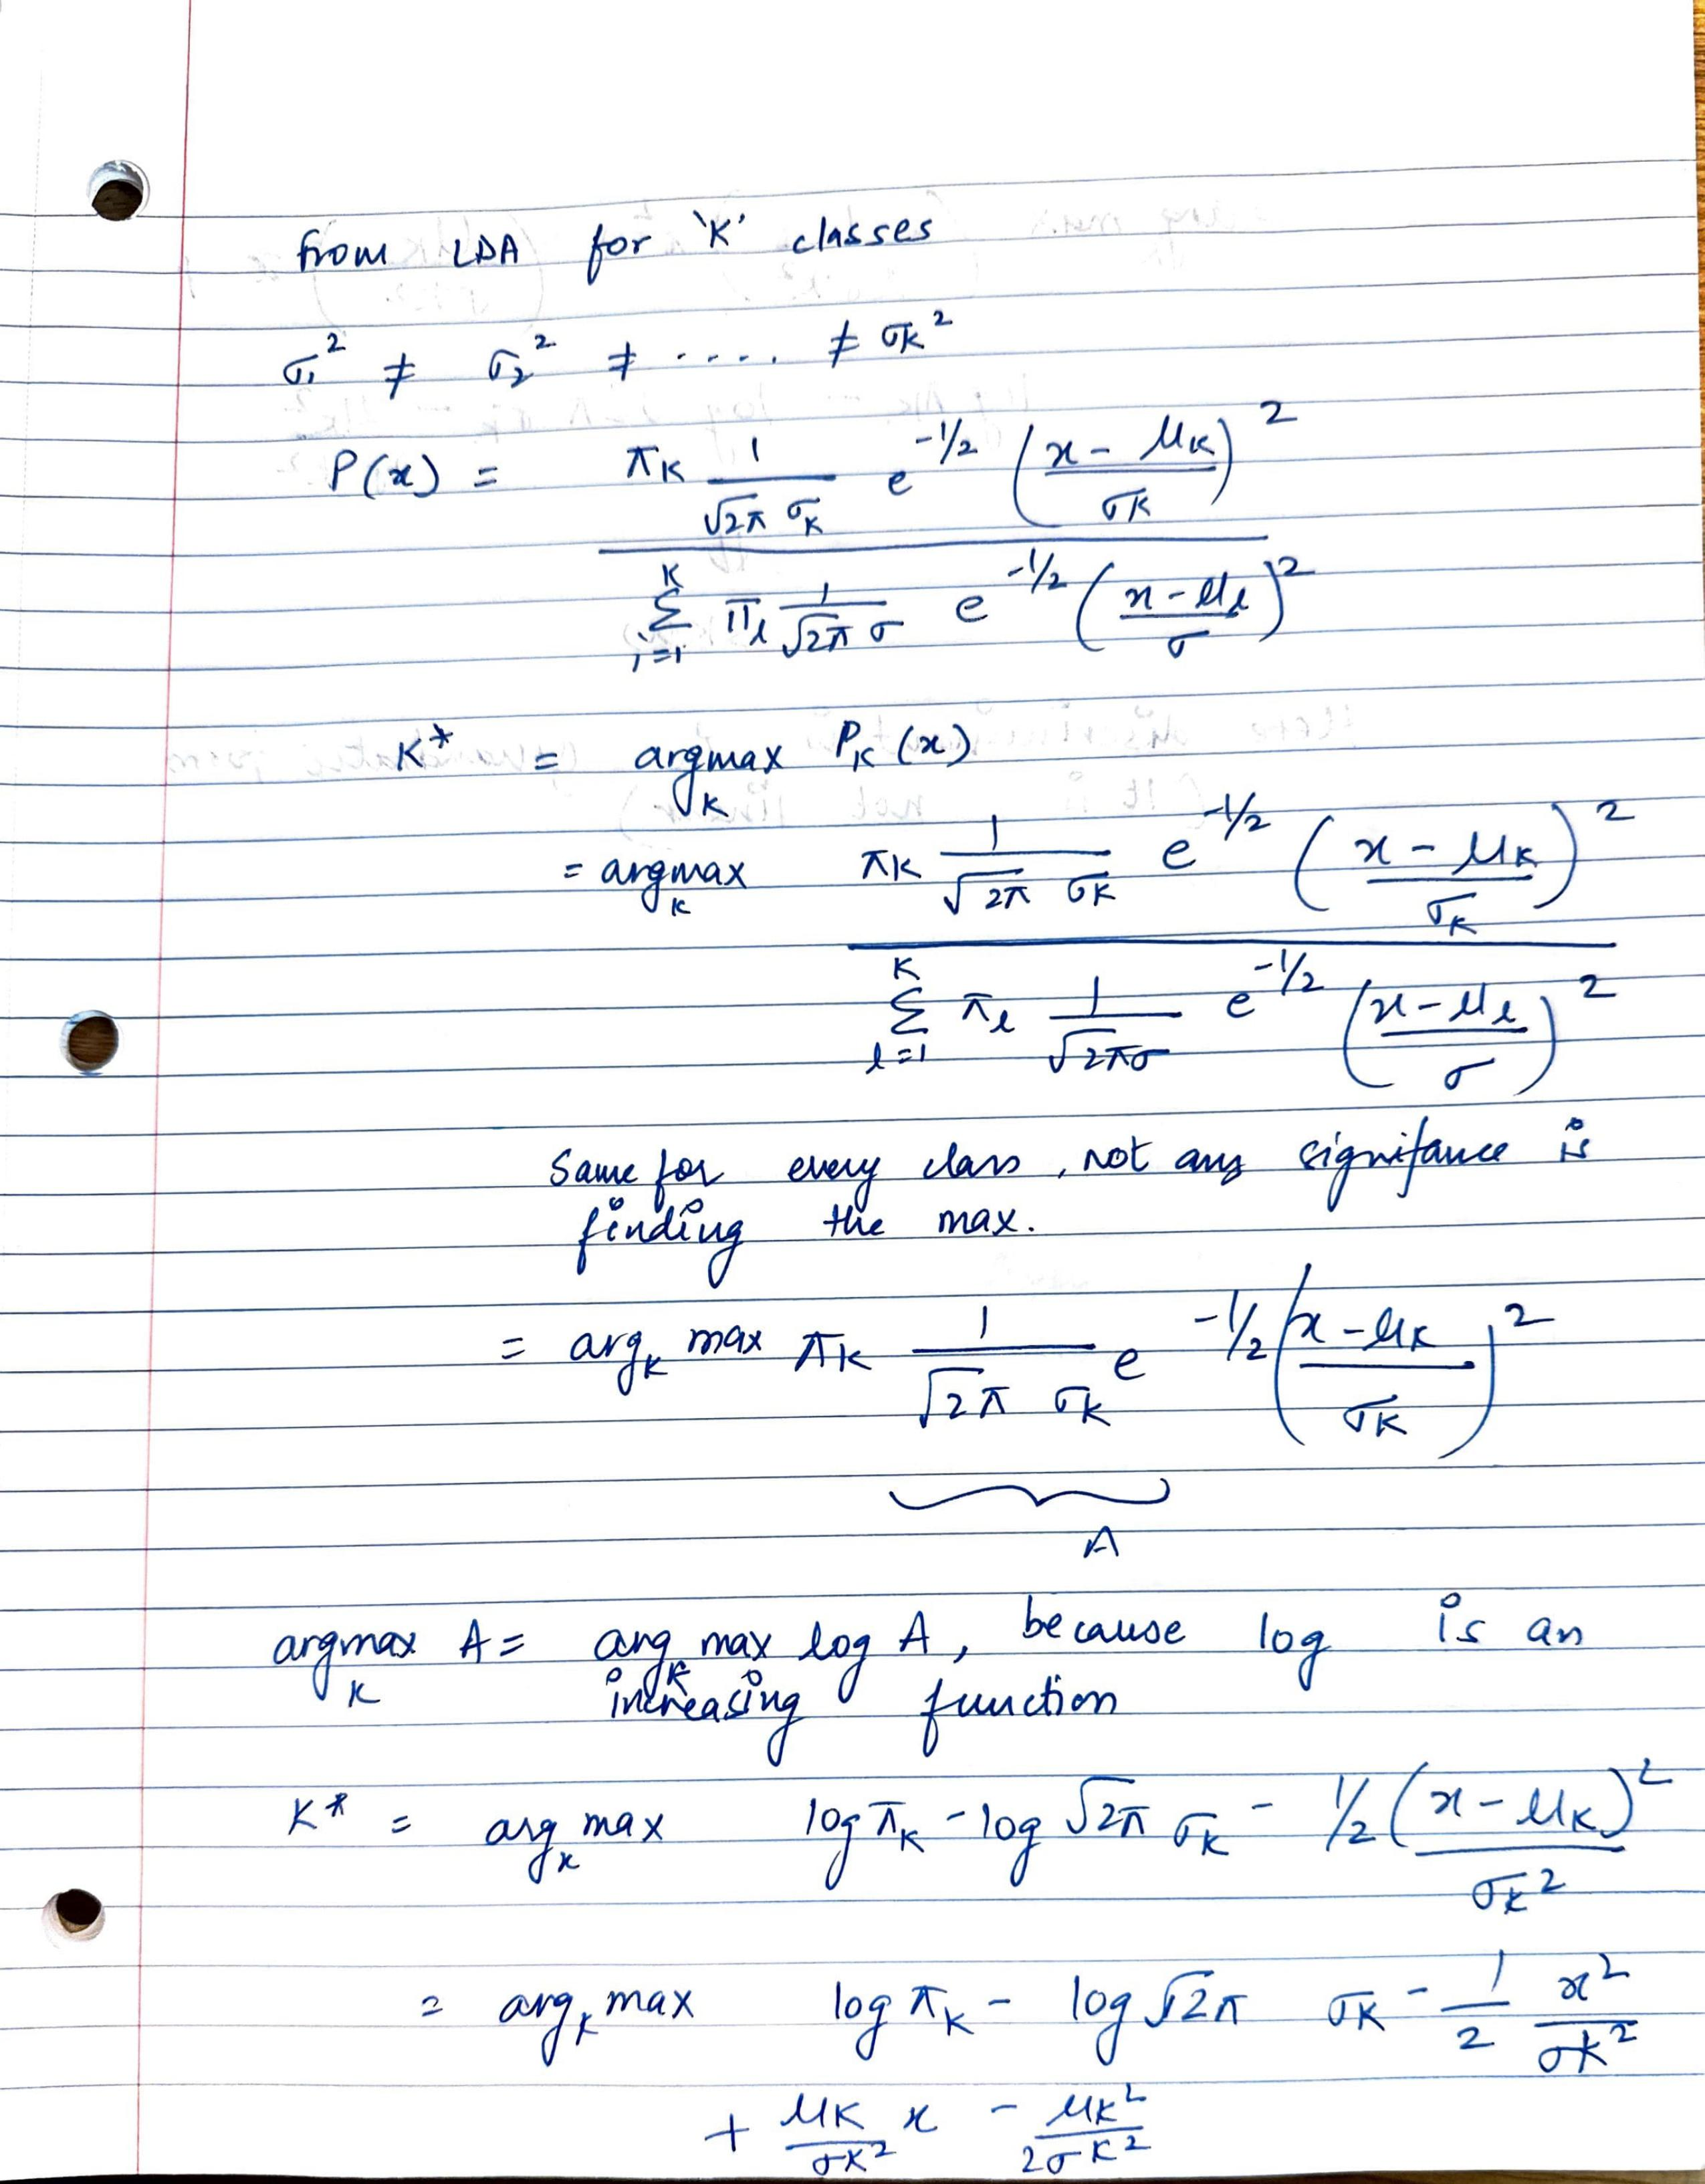

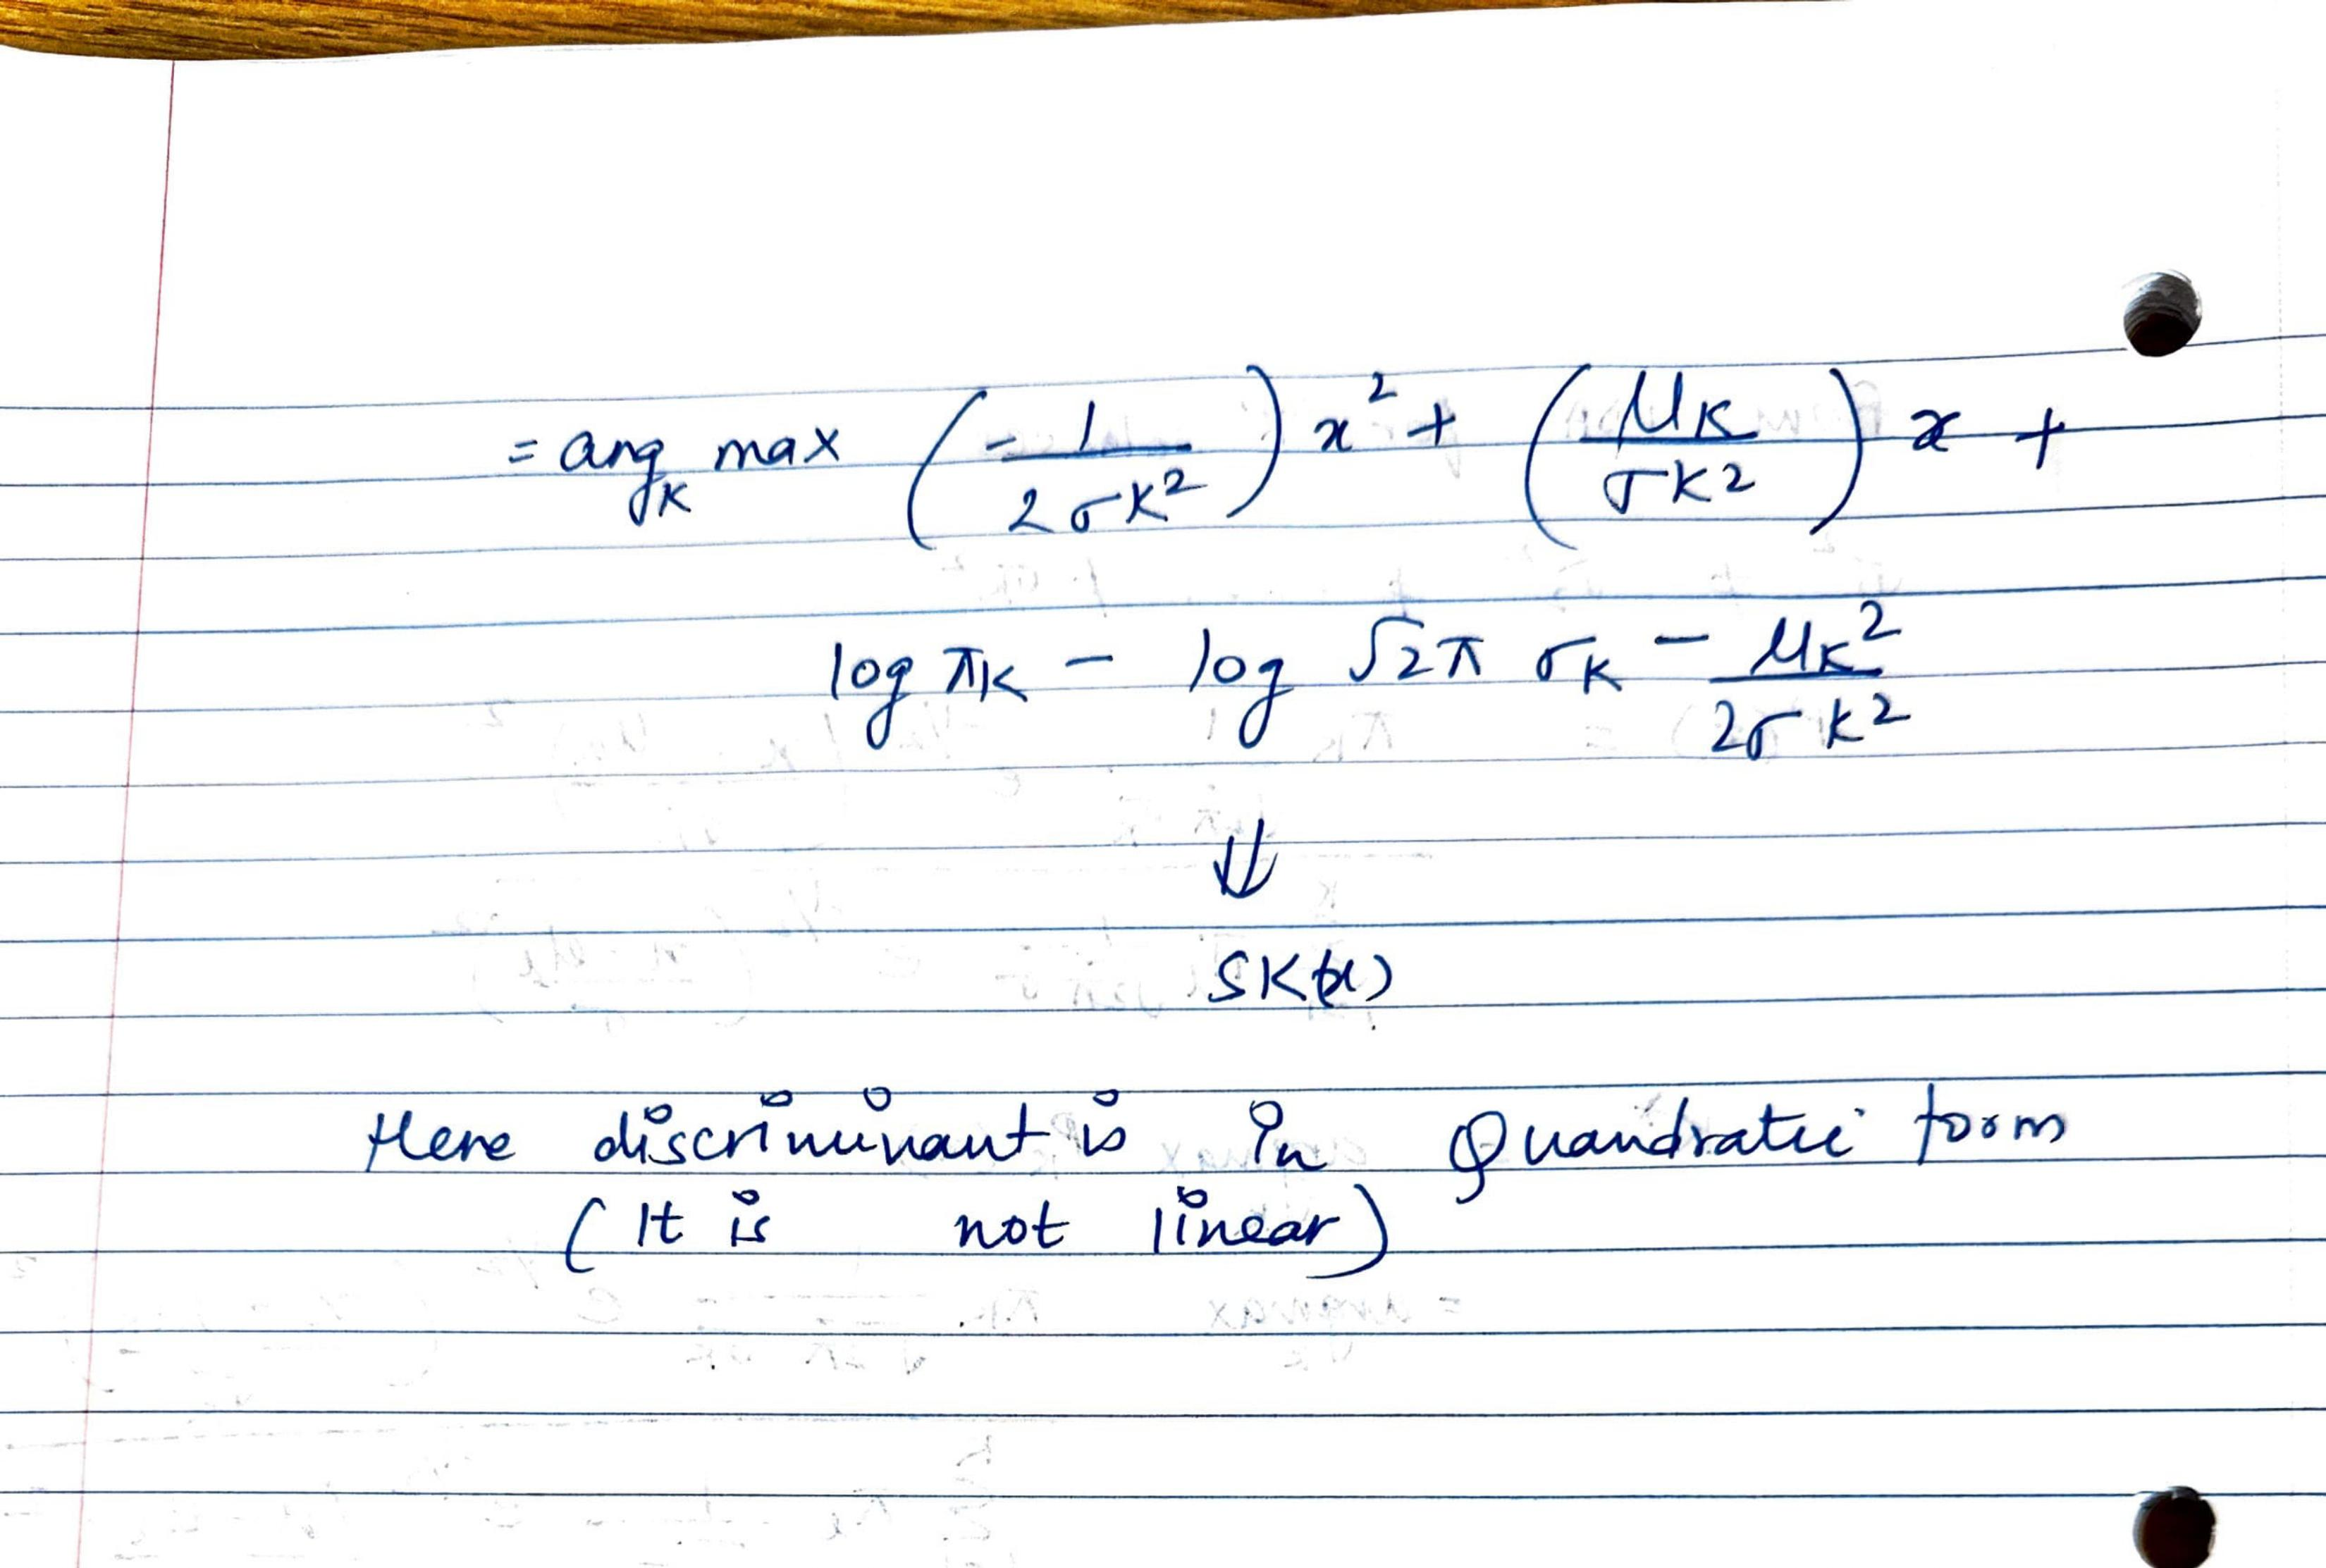

# 4. ISLR 4.8.7

Suppose that we wish to predict whether a given stock will issue a dividend this year (“Yes” or “No”) based on X, last year’s percent profit. We examine a large number of companies and discover that the mean value of X for companies that issued a dividend was $\bar{X}$ = 10, while the mean for those that didn’t was $\bar{X}$ = 0. In addition, the variance of X for these two sets of companies was $σ^2$ = 36. Finally, 80% of companies issued dividends. Assuming that X follows a normal distribution, predict the probability that a company will issue a dividend this year given that its percentage profit was X = 4 last year.

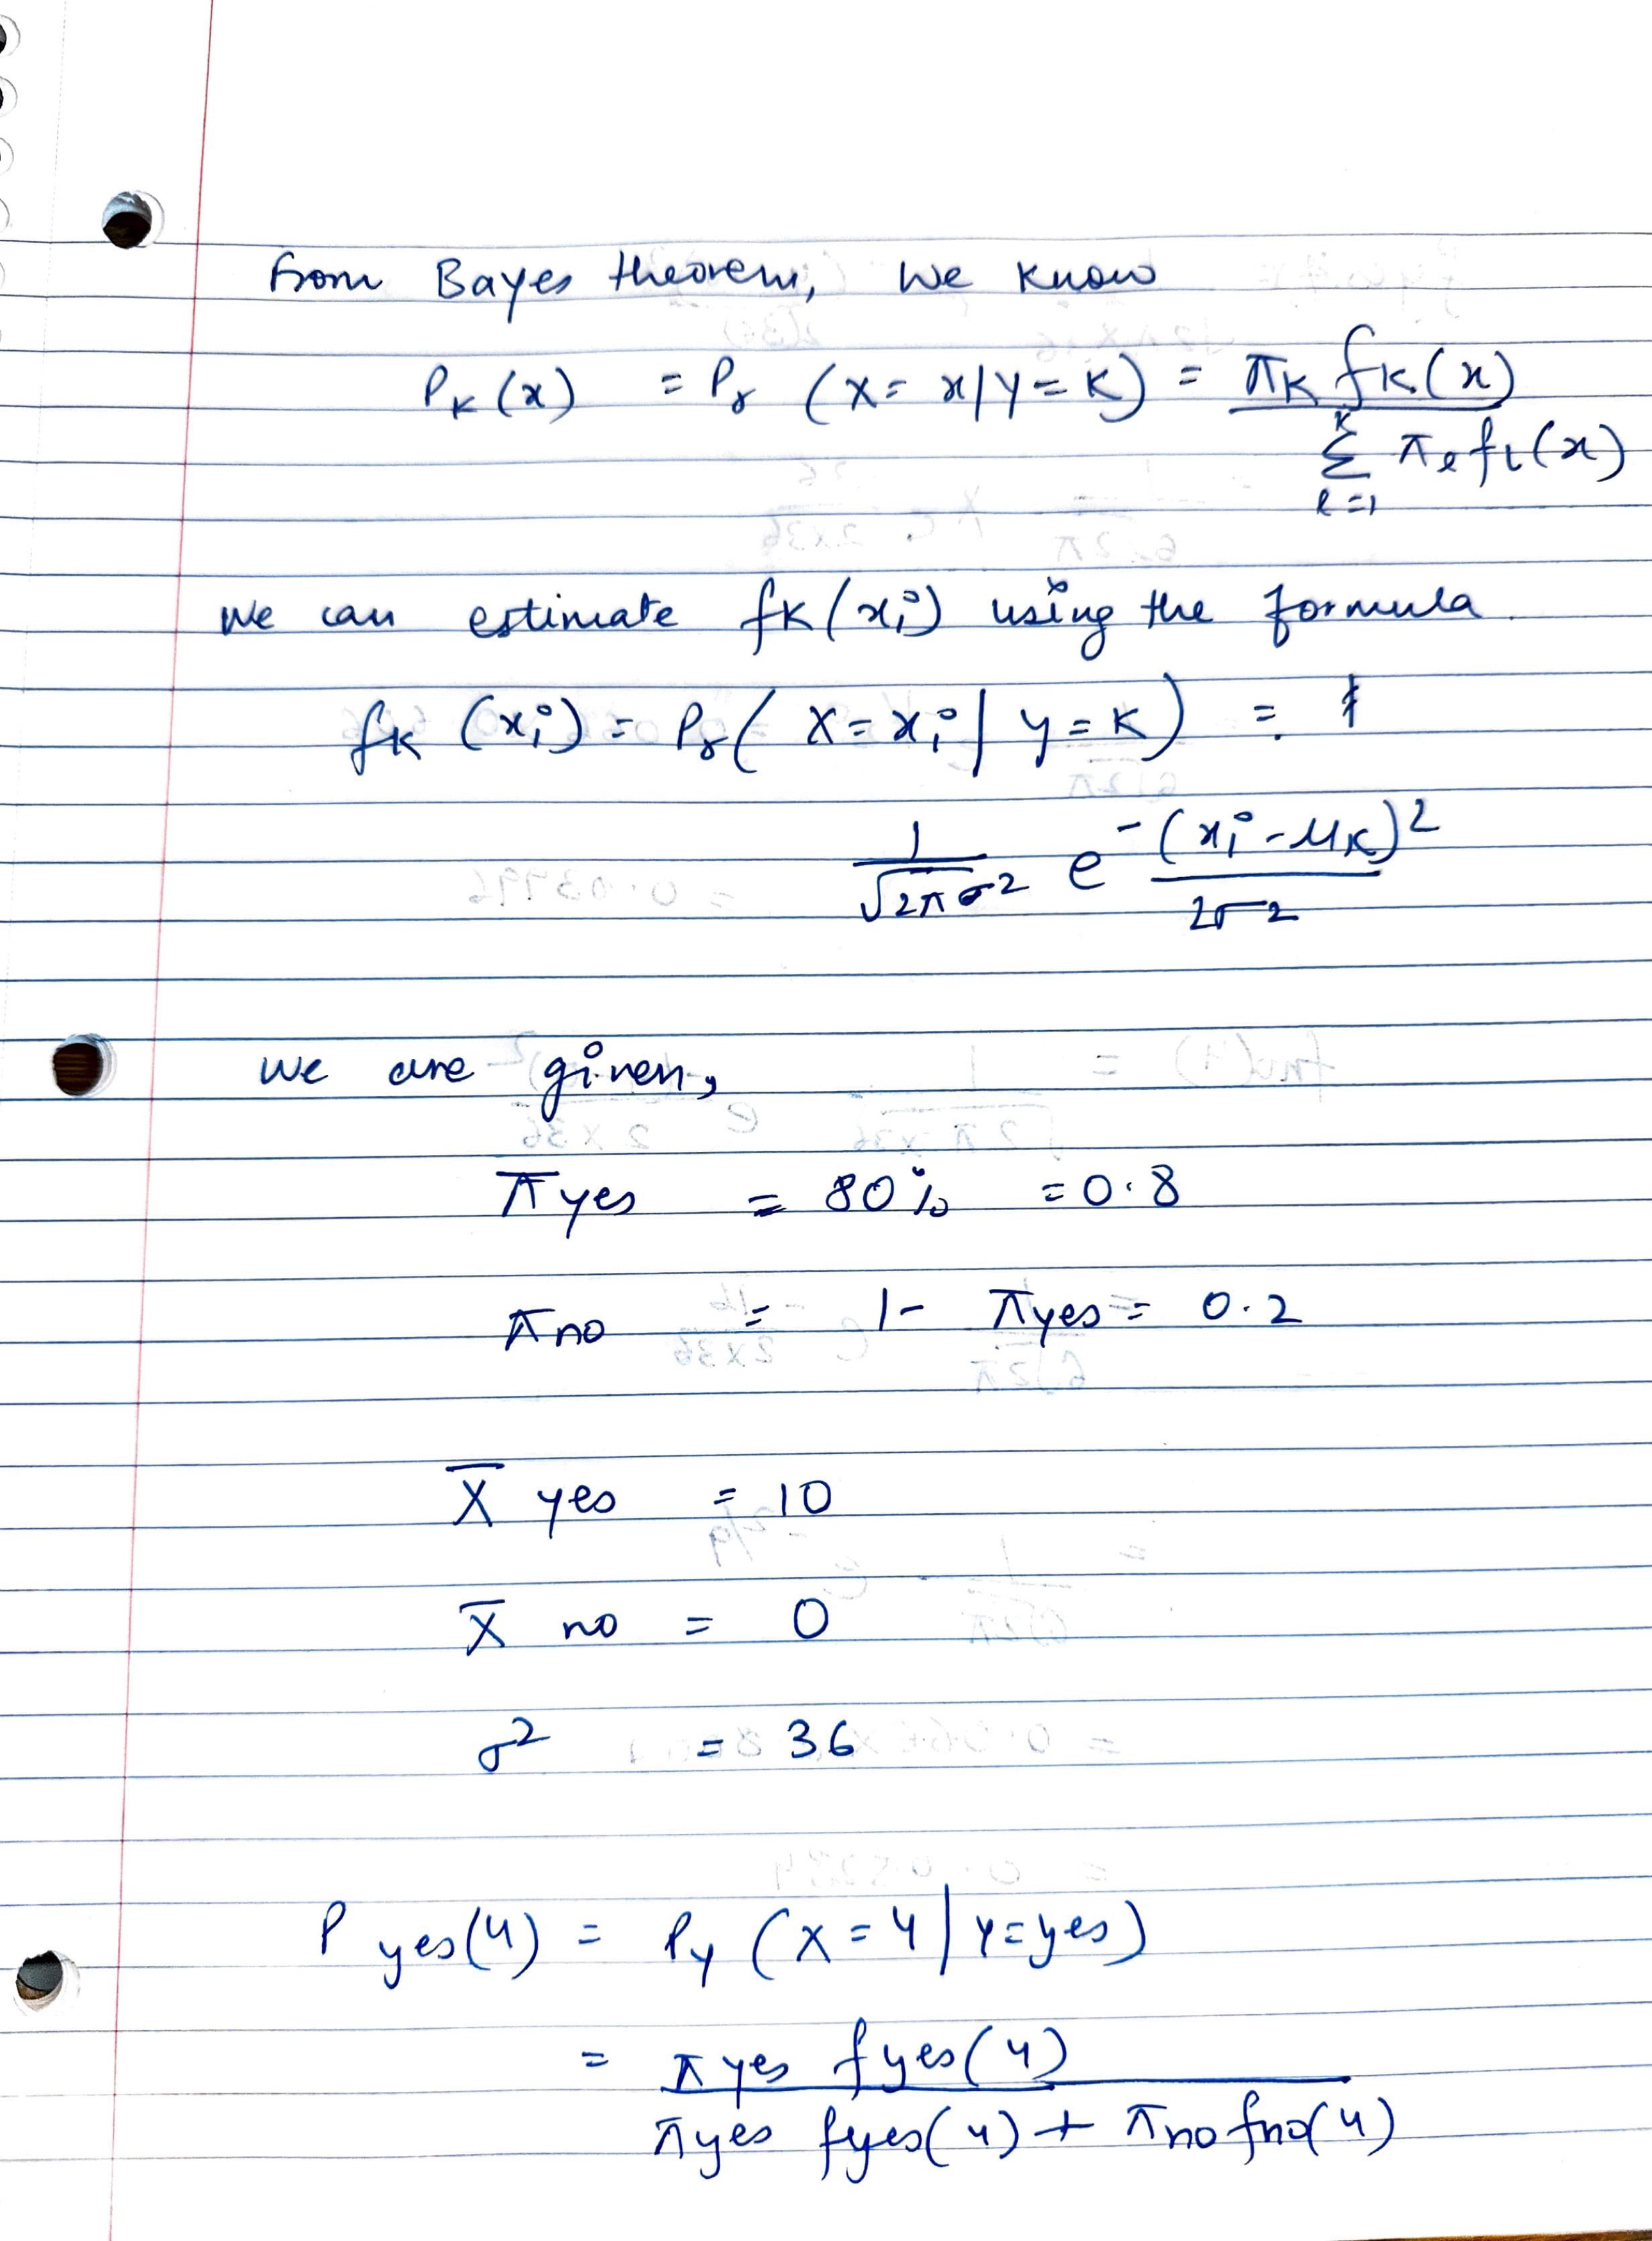

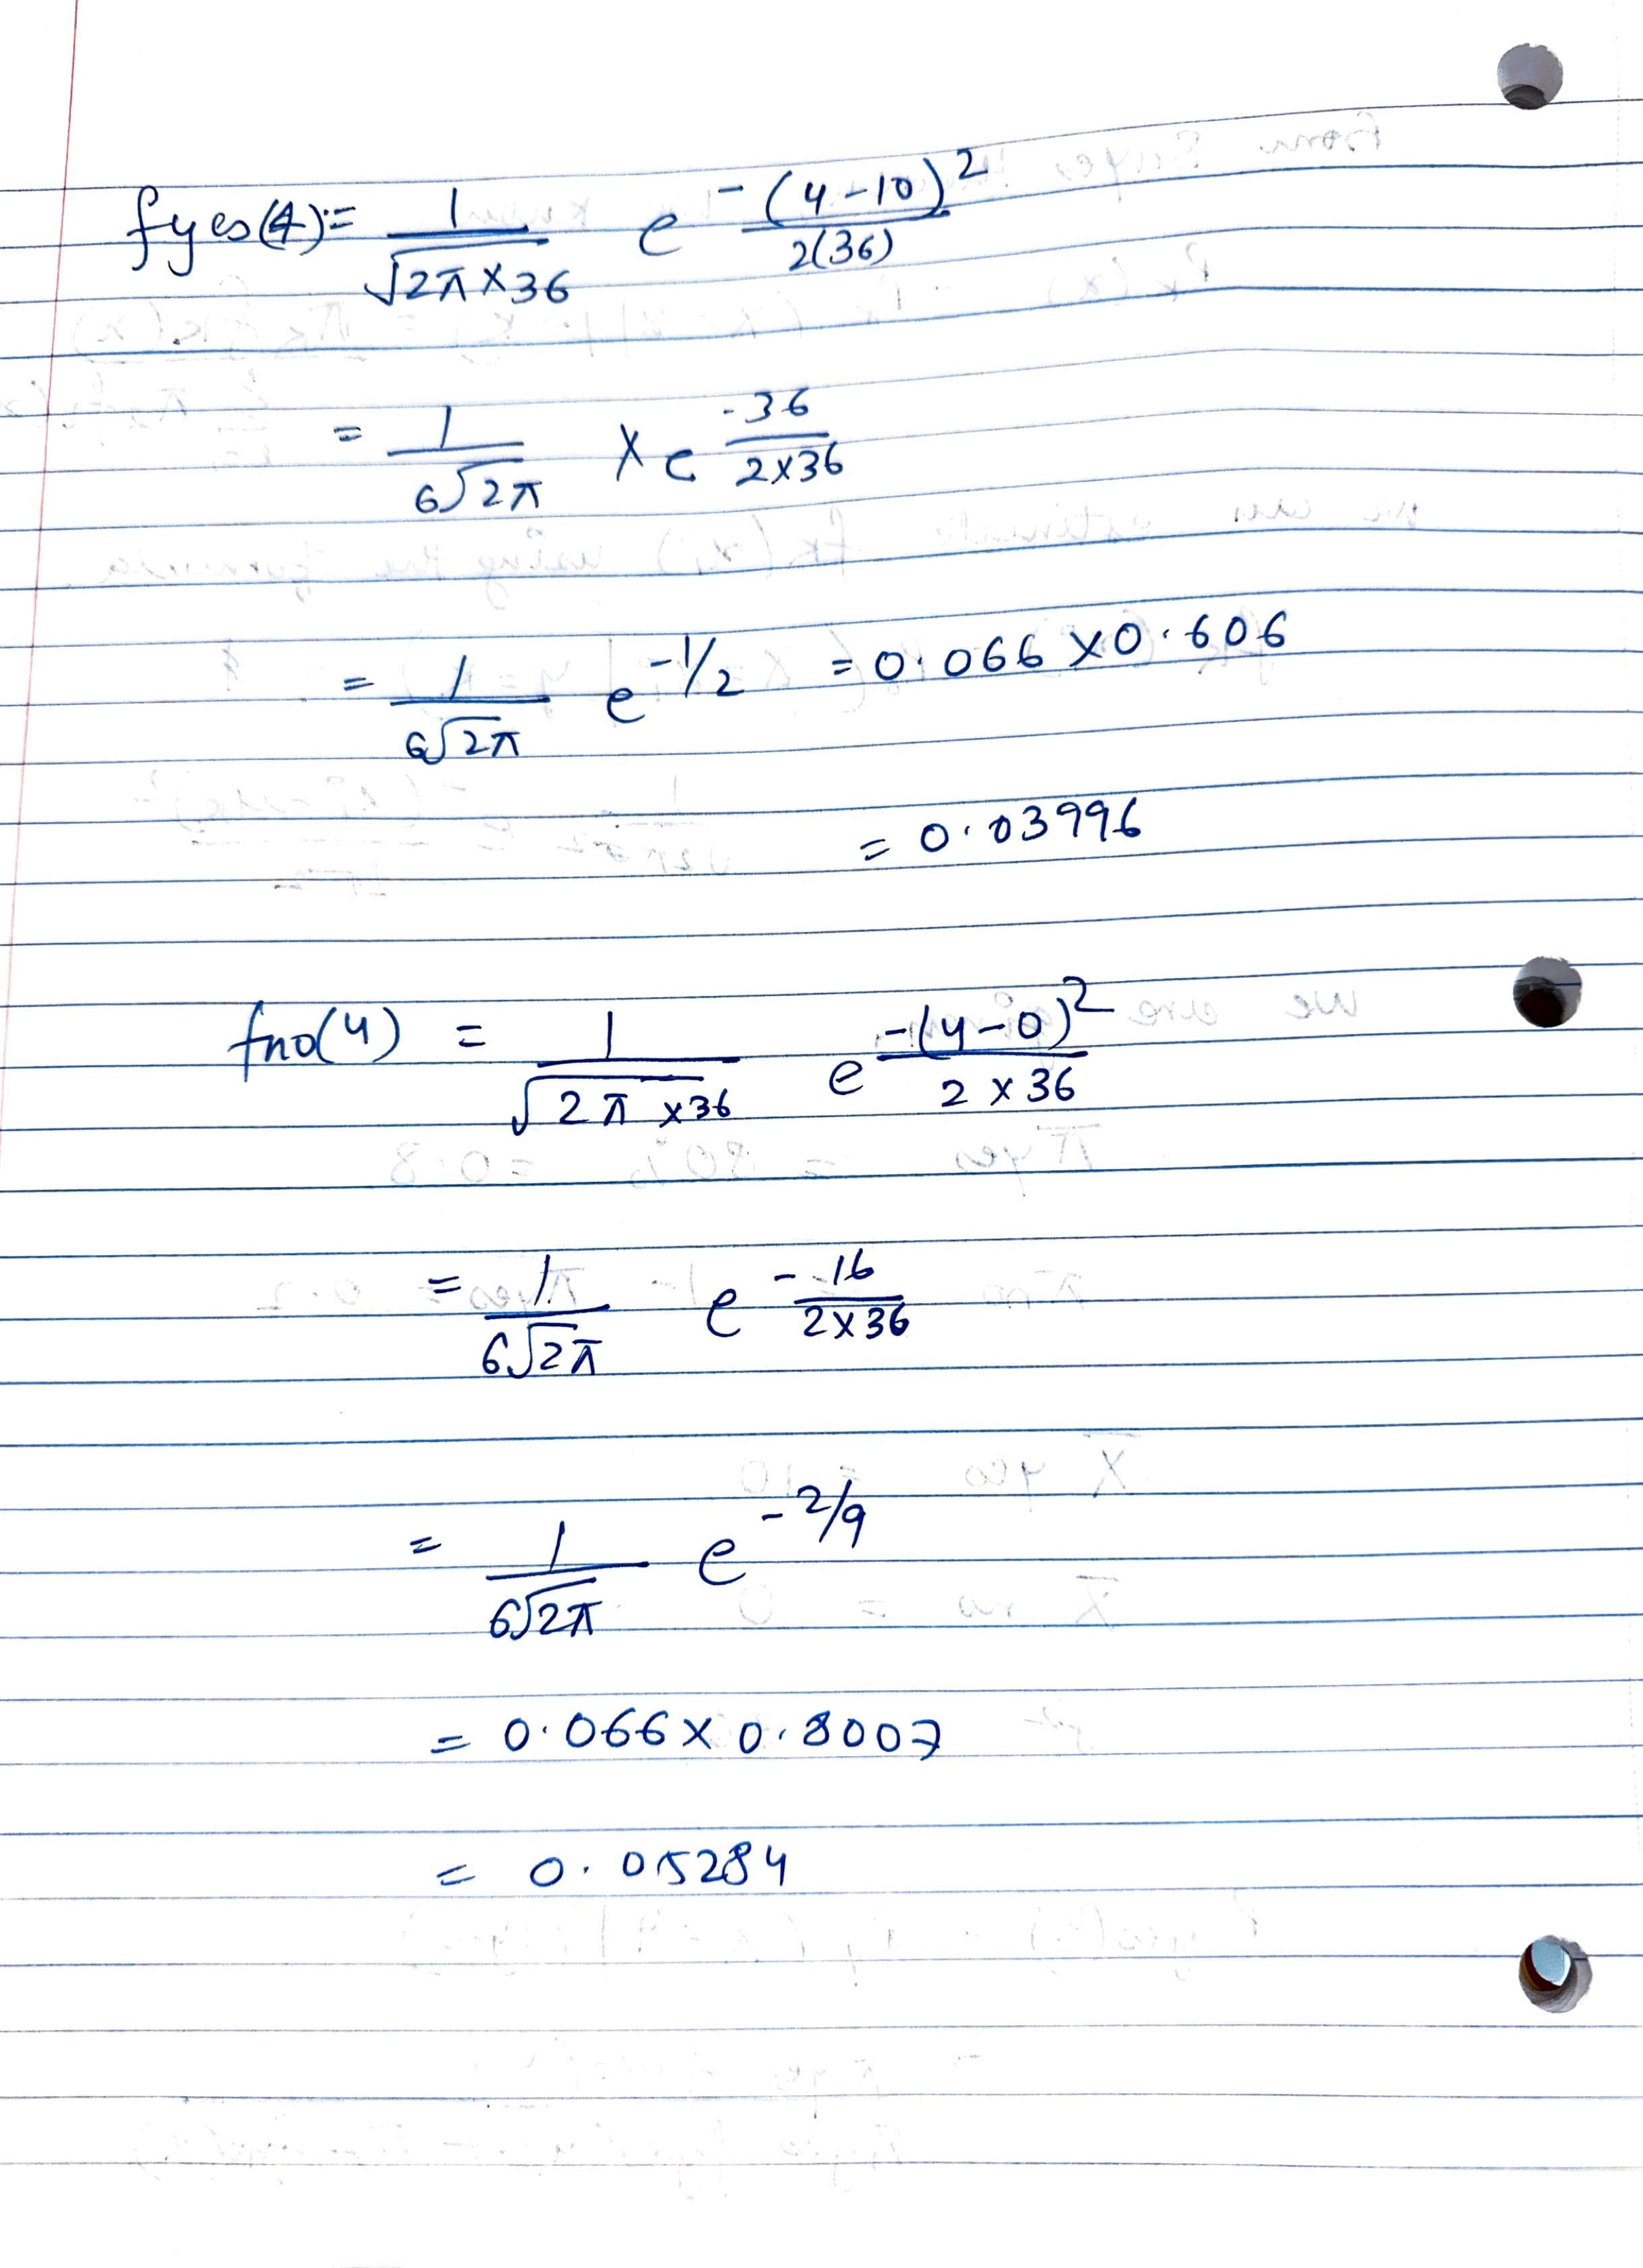

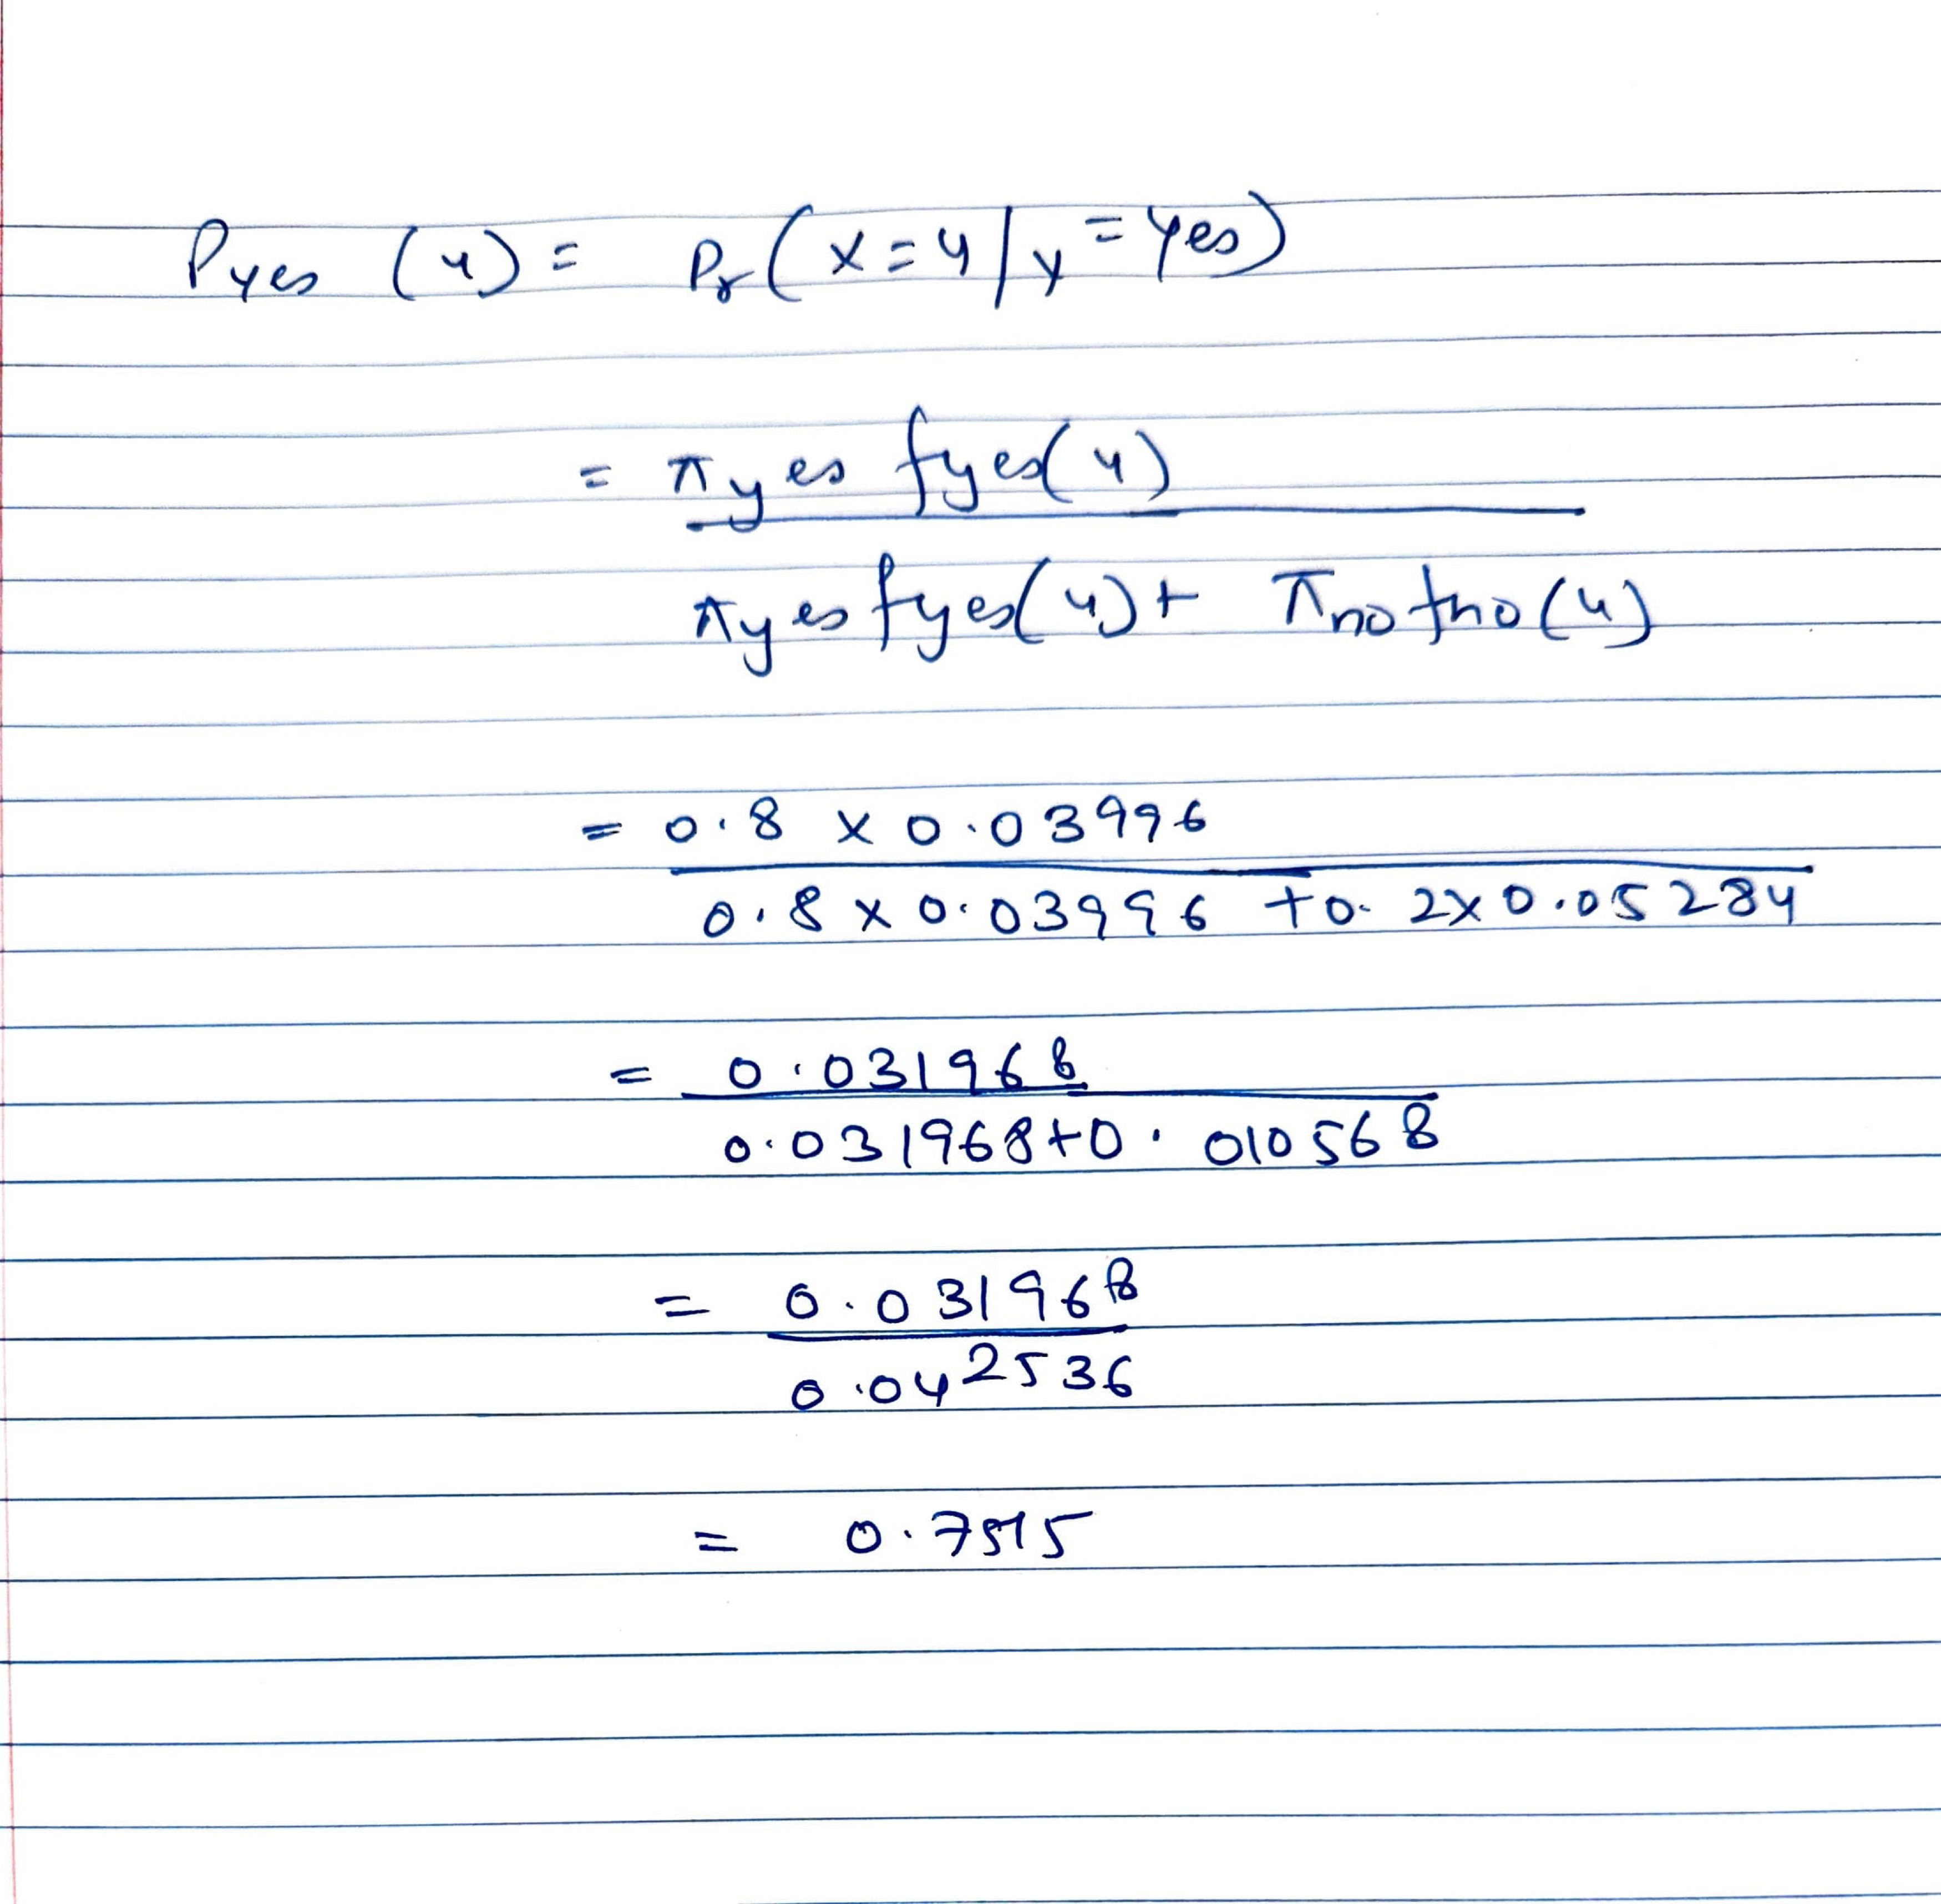